In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import json
%matplotlib inline

In [2]:
from shapely.geometry import Polygon, Point
from descartes.patch import PolygonPatch
from shapely.geometry import MultiLineString
BLUE = '#6699cc'
GRAY = '#999999'
DARKGRAY = '#333333'
YELLOW = '#ffcc33'
GREEN = '#339933'
RED = '#ff3333'
BLACK = '#000000'

In [3]:
#os.listdir("../problems")
data_dir = "../problems"
problems = [x for x in os.listdir(data_dir)]
problems = {
    int(x.split(".")[0].split("_")[1]): os.path.join(data_dir, x) for x in problems
}
#problems
def read_problem(path):
    with open(path) as f:
        data = json.load(f)
    return data


In [4]:
def set_limits(ax, x0, xN, y0, yN):
    ax.set_xlim(x0, xN)
    #ax.set_xticks(range(x0, xN+1))
    ax.set_ylim(y0, yN)
    #ax.set_yticks(range(y0, yN+1))
    ax.set_aspect("equal")
    

def plot_lines(ax, ob, color=GRAY, zorder=1, linewidth=3, alpha=1):
    for line in ob:
        x, y = line.xy
        ax.plot(x, y, color=color, linewidth=linewidth, solid_capstyle='round', zorder=zorder, alpha=alpha)

def plot_coords(ax, ob, color=GRAY, zorder=1, alpha=1):
    for line in ob:
        x, y = line.xy
        ax.plot(x, y, 'o', color=color, zorder=zorder, alpha=alpha)

def plot_bounds(ax, ob, zorder=1, alpha=1):
    x, y = zip(*list((p.x, p.y) for p in ob.boundary))
    ax.plot(x, y, 'o', color=BLACK, zorder=zorder, alpha=alpha)

    
def draw_problem(i):
    plt.close('all')
    data = read_problem(problems[i])
    hole = Polygon(data['hole'])
    xx = [x for (x, y) in data['hole']]
    yy = [y for (x, y) in data['hole']]
    SIZE=(3*3,3)
    fig, axes = plt.subplots(ncols=3, nrows=1, figsize=SIZE, dpi=90)
    ax = axes[0]
    patch = PolygonPatch(hole, facecolor=RED, edgecolor=RED, alpha=0.5, zorder=2)
    ax.add_patch(patch)

    set_limits(ax, np.min(xx)-1, np.max(xx)+3,  np.max(yy)+3, np.min(yy)-1)
    #ax.invert_yaxis()
    # figure
    ax = axes[1]
    figure = data['figure']
    vertices = figure['vertices']
    edges = figure['edges']
    figure_shape = MultiLineString([(vertices[s], vertices[e]) for s, e in edges])
    plot_coords(ax, figure_shape)
    # plot_bounds(ax, figure_shape)
    plot_lines(ax, figure_shape)
    xx = [x for (x, y) in vertices]
    yy = [y for (x, y) in vertices]
    set_limits(ax, np.min(xx)-1, np.max(xx)+3,  np.max(yy)+3, np.min(yy)-1)
    # both
    ax=axes[2]
    patch = PolygonPatch(hole, facecolor=RED, edgecolor=RED, alpha=0.5, zorder=2)

    ax.add_patch(patch)
    plot_coords(ax, figure_shape)
    # plot_bounds(ax, figure_shape)
    plot_lines(ax, figure_shape)
    xx = [x for (x, y) in vertices] + [x for (x, y) in data['hole']]
    yy = [y for (x, y) in vertices] + [y for (x, y) in data['hole']]

    set_limits(ax, np.min(xx)-1, np.max(xx)+3,  np.max(yy)+3, np.min(yy)-1)
    plt.show()


In [5]:
from ipywidgets import interact

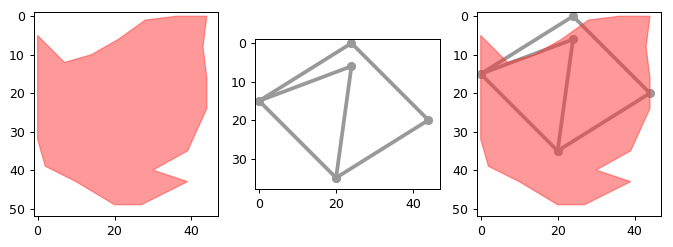

In [159]:
draw_problem(30)

In [7]:
def draw_pair(hole_poly, figure_shape, filename=None, label="", new_vert=[]):
    fig = plt.figure(figsize=(3, 3))
    ax = plt.gca()
    patch = PolygonPatch(hole_poly, facecolor=RED, edgecolor=RED, alpha=0.5, zorder=2)
    ax.add_patch(patch)
    plot_coords(ax, figure_shape)
    # plot_bounds(ax, figure_shape)
    plot_lines(ax, figure_shape)
    if len(new_vert) == 0:
        [x.coords[:]for x in figure_shape.geoms]
        new_vert = sorted(set([ c for x in figure_shape.geoms for c in x.coords[:]]))
    # print(repr(new_vert), flush=True)
    #dist = get_distance(hole_poly, figure_shape)
    dist = get_distance(data, new_vert)
    plt.title(f"Current distance: {dist} - {label}")
    # hole_poly.bounds
    x0, y0, x1, y1 = hole_poly.union(figure_shape).bounds

    set_limits(ax, x0 - 1, x1+3,  y1 + 3, y0 - 1)
    
    if filename is not None:
        fig.savefig(filename)
    plt.show()

In [42]:
def get_dist(p, q):
    return (p[0]-q[0])**2+(p[1]-q[1])**2

def get_distance_old(hole_poly, figure_shape):
    figure_vertices = sorted(set([y for x in figure_shape.geoms for y in x.coords]))
    min_distances = [
        np.min([get_dist(p, q) for q in figure_vertices])
        for p in hole_poly.exterior.coords
    ]
    return np.sum(min_distances)

def get_distance(data, new_vertices):
    min_distances = [
        np.min([get_dist(p, q) for q in new_vertices])
        for p in data['hole']
    ]
    return np.sum(min_distances)

In [312]:
for k in range(16, 60):
    data = read_problem(problems[k])
    figure = data['figure']
    hvertices = data['hole']
    vertices = figure['vertices']
    n = len(hvertices)
    edges = [(i, j) for i, j in zip(np.arange(n), (np.arange(n)+1)%n)]
    hedges = [(hvertices[i], hvertices[j]) for i,j in edges]
    fedges = [(vertices[i], vertices[j]) for i, j in figure['edges']]
    # fvertices = len(data['figure']['vertices'])
    # if hvertices==fvertices:
    #     print(i)
    distances = []
    for i, p in enumerate(hedges):
        for j, q in enumerate(fedges):
            dp = get_dist(*p)
            dq = get_dist(*q)
            if dp==dq:
                distances.append((dp, i, j))
    if len(distances) > 0:
        print(k, distances, len(distances), len(hvertices), len(vertices))
        problem_id = k
        break

16 [(533, 0, 2), (557, 1, 4), (557, 2, 4), (533, 3, 2)] 4 5 5


In [247]:
data = read_problem(problems[16])

In [248]:
from igraph import *
g = Graph(data['figure']['edges'])

In [249]:
# layout = g.layout_kamada_kawai()

In [250]:
# list(layout)

In [251]:
distances

[(533, 0, 2), (557, 1, 4), (557, 2, 4), (533, 3, 2)]

In [252]:
figure

{'edges': [[0, 1], [0, 2], [1, 3], [2, 4], [3, 4]],
 'vertices': [[8, 6], [26, 22], [21, 25], [19, 0], [0, 14]]}

In [253]:
positions_lists = []
for d, i, j in distances:
    # print(i, j, edges[i], figure['edges'][j])
    if len(positions_lists) < 1:
        vi, vj = edges[i]
        hi, hj = figure['edges'][j]
        positions_lists.append([(hi, vi), (hj, vj)])
        positions_lists.append([(hi, vj), (hj, vi)])
        continue
    new_pos = []
    vi, vj = edges[i]
    hi, hj = figure['edges'][j]
    for poslist in positions_lists:
        if (hi, vi) not in poslist:
            new_pos.append(poslist+[(hi, vi)])
        if (hj, vj) not in poslist:
            new_pos.append(poslist+[(hj, vj)])
        if (hi, vj) not in poslist:
            new_pos.append(poslist+[(hi, vj)])
        if (hi, vj) not in poslist:
            new_pos.append(poslist+[(hi, vj)])
    positions_lists = new_pos

In [254]:
mapping = dict(positions_lists[0])
{k: data['hole'][v] for k, v in mapping.items()}

{1: [22, 38], 3: [36, 19], 4: [36, 19]}

In [255]:
data['hole']

[[0, 7], [22, 0], [36, 19], [22, 38], [0, 31]]

In [256]:
mapping

{1: 3, 3: 2, 4: 2}

In [257]:
set(positions_lists[0])

{(1, 0), (1, 3), (3, 1), (3, 2), (4, 2)}

In [758]:
problem_id=23 # 22
data = read_problem(problems[problem_id])

In [759]:
targets = data['hole']
sources = data['figure']['vertices']
epsilon = data['epsilon']
orig_edges = data['figure']['edges']

In [760]:
from collections import defaultdict

def vect(u, v):
    return [y - x for x, y in zip(u, v)]

def mult(u, m):
    return [m*x for x in u]
def len2(u):
    return np.sum([x**2 for x in u])

def length(u):
    return np.sqrt(len2(u))

def sums(*b):
    # print(b, "b", len(b))
    if len(b) == 1:
        #print("return b")
        return b[0]
    return [np.sum(x) for x in zip(*b)]

def means(*b):
    return [np.mean(x) for x in zip(*b)]
    

def compute_forces(current_pos, orig_edges, targets, sources, epsilon, magnets=dict()):
    forces = defaultdict(list)
    # center force
#     if len(magnets) == 0:
#         z = means(current_pos)
#         for i, x in enumerate(current_pos):
#             forces[i].append(mult(vect(z, x), 0.1))
        
    for src, tgts in magnets.items():
        u = current_pos[src]
        for t in tgts:
            v = targets[t]
            d = vect(u, v)
            #print(src, tgts, length(d))
            if length(d) < 10:# and len(tgts)==1: # was 1 condition
                m = 1.
            elif length(d) < 1:
                m = 0
            else:
                m = 0.5 # was:0.5
            forces[src].append(mult(d, m))
    for s, e in orig_edges:
        a, b = current_pos[s], current_pos[e]
        u, v = sources[s], sources[e]
        dn = len2(vect(a, b))
        do = len2(vect(u, v))
        if (dn - do)*1000000 >= epsilon*do: # dn/do-1 >= epsilon/1000000:
            direction = 1*(np.sqrt(dn)-np.sqrt(do))
        elif (dn - do)*1000000 <= - epsilon*do:
            direction = -1*(np.sqrt(do)-np.sqrt(dn))
        else:
            direction = 0.01
        if direction > 0:
            if not s in magnets or len(magnets[s])>1:
                forces[s].append(mult(vect(a, b), direction))
            if not e in magnets or len(magnets[e])>1:
                forces[e].append(mult(vect(b, a), direction))
    for k in range(len(sources)):
        if k not in forces:
            forces[k].append((0, 0))
    return forces
    
    pass
def modify_pos(pos, delta, forces, verbose=True):
    force = means(*forces)
    if verbose:
        print(forces)
        print(pos, force)
    
    #print(pos, delta, force)
    #print([(p,f) for p, f in zip(pos, force)])
    return [ (p + f*delta) for p, f in zip(pos, force)]

[[0.0, 0.0]]
[0, 0] [0.0, 0.0]
[[0.0, 0.0]]
[0, 34] [0.0, 0.0]
[[0.0, 0.0]]
[10, 69] [0.0, 0.0]
[[0.0, 0.0]]
[30, 17] [0.0, 0.0]
[[2.0, -8.0]]
[39, 80] [2.0, -8.0]
[[6.0, -6.0]]
[54, 47] [6.0, -6.0]


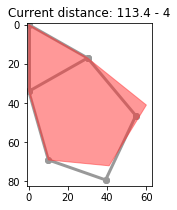

[[0.0, 0.0]]
[0.0, 0.0] [0.0, 0.0]
[[0.0, 0.0]]
[0.0, 34.0] [0.0, 0.0]
[[0.0, 0.0]]
[10.0, 69.0] [0.0, 0.0]
[[0.0, 0.0]]
[30.0, 17.0] [0.0, 0.0]
[[1.7999999999999972, -7.200000000000003]]
[39.2, 79.2] [1.7999999999999972, -7.200000000000003]
[[5.399999999999999, -5.399999999999999]]
[54.6, 46.4] [5.399999999999999, -5.399999999999999]


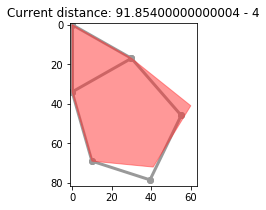

[[0.0, 0.0]]
[0.0, 0.0] [0.0, 0.0]
[[0.0, 0.0]]
[0.0, 34.0] [0.0, 0.0]
[[0.0, 0.0]]
[10.0, 69.0] [0.0, 0.0]
[[0.0, 0.0]]
[30.0, 17.0] [0.0, 0.0]
[[1.6199999999999974, -6.480000000000004]]
[39.38, 78.48] [1.6199999999999974, -6.480000000000004]
[[4.859999999999999, -4.859999999999999]]
[55.14, 45.86] [4.859999999999999, -4.859999999999999]


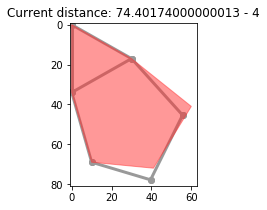

[[0.0, 0.0]]
[0.0, 0.0] [0.0, 0.0]
[[0.0, 0.0]]
[0.0, 34.0] [0.0, 0.0]
[[0.0, 0.0]]
[10.0, 69.0] [0.0, 0.0]
[[0.0, 0.0]]
[30.0, 17.0] [0.0, 0.0]
[[1.4579999999999984, -5.832000000000008]]
[39.542, 77.83200000000001] [1.4579999999999984, -5.832000000000008]
[[4.374000000000002, -4.374000000000002]]
[55.626, 45.374] [4.374000000000002, -4.374000000000002]


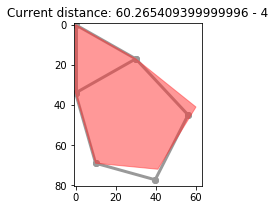

[[0.0, 0.0]]
[0.0, 0.0] [0.0, 0.0]
[[0.0, 0.0]]
[0.0, 34.0] [0.0, 0.0]
[[0.0, 0.0]]
[10.0, 69.0] [0.0, 0.0]
[[0.0, 0.0]]
[30.0, 17.0] [0.0, 0.0]
[[1.3121999999999971, -5.248800000000003]]
[39.6878, 77.2488] [1.3121999999999971, -5.248800000000003]
[[3.9365999999999985, -3.9365999999999985]]
[56.0634, 44.9366] [3.9365999999999985, -3.9365999999999985]


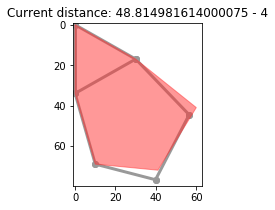

[[0.0, 0.0]]
[0.0, 0.0] [0.0, 0.0]
[[0.0, 0.0]]
[0.0, 34.0] [0.0, 0.0]
[[0.0, 0.0]]
[10.0, 69.0] [0.0, 0.0]
[[0.0, 0.0]]
[30.0, 17.0] [0.0, 0.0]
[[1.1809799999999981, -4.723920000000007]]
[39.81902, 76.72392] [1.1809799999999981, -4.723920000000007]
[[3.5429400000000015, -3.5429400000000015]]
[56.45706, 44.54294] [3.5429400000000015, -3.5429400000000015]


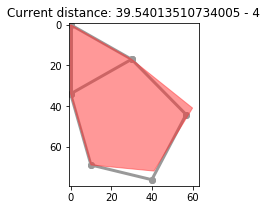

[[0.0, 0.0]]
[0.0, 0.0] [0.0, 0.0]
[[0.0, 0.0]]
[0.0, 34.0] [0.0, 0.0]
[[0.0, 0.0]]
[10.0, 69.0] [0.0, 0.0]
[[0.0, 0.0]]
[30.0, 17.0] [0.0, 0.0]
[[1.0628820000000019, -4.2515280000000075]]
[39.937118, 76.25152800000001] [1.0628820000000019, -4.2515280000000075]
[[3.1886459999999985, -3.1886459999999985]]
[56.811354, 44.188646] [3.1886459999999985, -3.1886459999999985]


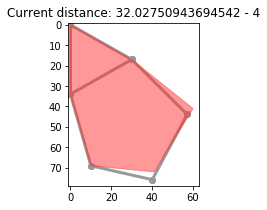

[[0.0, 0.0]]
[0.0, 0.0] [0.0, 0.0]
[[0.0, 0.0]]
[0.0, 34.0] [0.0, 0.0]
[[0.0, 0.0]]
[10.0, 69.0] [0.0, 0.0]
[[0.0, 0.0]]
[30.0, 17.0] [0.0, 0.0]
[[0.9565938000000003, -3.826375200000001]]
[40.0434062, 75.8263752] [0.9565938000000003, -3.826375200000001]
[[2.869781400000001, -2.869781400000001]]
[57.1302186, 43.8697814] [2.869781400000001, -2.869781400000001]


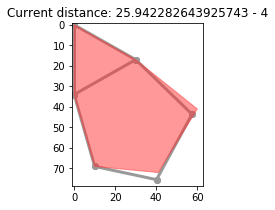

[[0.0, 0.0]]
[0.0, 0.0] [0.0, 0.0]
[[0.0, 0.0]]
[0.0, 34.0] [0.0, 0.0]
[[0.0, 0.0]]
[10.0, 69.0] [0.0, 0.0]
[[0.0, 0.0]]
[30.0, 17.0] [0.0, 0.0]
[[0.8609344199999995, -3.443737679999998]]
[40.13906558, 75.44373768] [0.8609344199999995, -3.443737679999998]
[[2.5828032599999986, -2.5828032599999986]]
[57.41719674, 43.58280326] [2.5828032599999986, -2.5828032599999986]


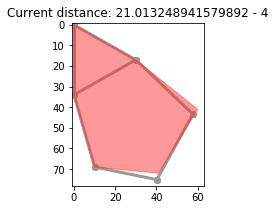

[[0.0, 0.0]]
[0.0, 0.0] [0.0, 0.0]
[[0.0, 0.0]]
[0.0, 34.0] [0.0, 0.0]
[[0.0, 0.0]]
[10.0, 69.0] [0.0, 0.0]
[[0.0, 0.0]]
[30.0, 17.0] [0.0, 0.0]
[[0.7748409780000003, -3.099363912000001]]
[40.225159022, 75.099363912] [0.7748409780000003, -3.099363912000001]
[[2.324522934000001, -2.324522934000001]]
[57.675477066, 43.324522934] [2.324522934000001, -2.324522934000001]


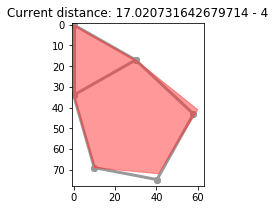

[[0.0, 0.0]]
[0.0, 0.0] [0.0, 0.0]
[[0.0, 0.0]]
[0.0, 34.0] [0.0, 0.0]
[[0.0, 0.0]]
[10.0, 69.0] [0.0, 0.0]
[[0.0, 0.0]]
[30.0, 17.0] [0.0, 0.0]
[[0.6973568801999974, -2.789427520800004]]
[40.3026431198, 74.7894275208] [0.6973568801999974, -2.789427520800004]
[[2.0920706405999994, -2.0920706405999994]]
[57.9079293594, 43.0920706406] [2.0920706405999994, -2.0920706405999994]


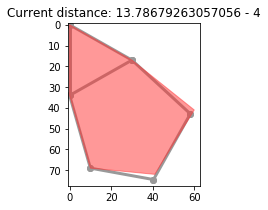

[[0.0, 0.0]]
[0.0, 0.0] [0.0, 0.0]
[[0.0, 0.0]]
[0.0, 34.0] [0.0, 0.0]
[[0.0, 0.0]]
[10.0, 69.0] [0.0, 0.0]
[[0.0, 0.0]]
[30.0, 17.0] [0.0, 0.0]
[[0.6276211921800012, -2.510484768720005]]
[40.37237880782, 74.51048476872] [0.6276211921800012, -2.510484768720005]
[[1.8828635765399966, -1.8828635765399966]]
[58.11713642346, 42.88286357654] [1.8828635765399966, -1.8828635765399966]


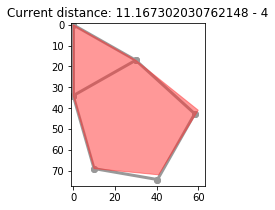

[[0.0, 0.0]]
[0.0, 0.0] [0.0, 0.0]
[[0.0, 0.0]]
[0.0, 34.0] [0.0, 0.0]
[[0.0, 0.0]]
[10.0, 69.0] [0.0, 0.0]
[[0.0, 0.0]]
[30.0, 17.0] [0.0, 0.0]
[[0.5648590729620011, -2.2594362918480044]]
[40.435140927038, 74.259436291848] [0.5648590729620011, -2.2594362918480044]
[[1.6945772188859962, -1.6945772188859962]]
[58.305422781114004, 42.694577218885996] [1.6945772188859962, -1.6945772188859962]


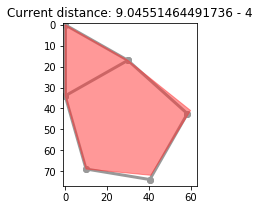

[[0.0, 0.0]]
[0.0, 0.0] [0.0, 0.0]
[[0.0, 0.0]]
[0.0, 34.0] [0.0, 0.0]
[[0.0, 0.0]]
[10.0, 69.0] [0.0, 0.0]
[[0.0, 0.0]]
[30.0, 17.0] [0.0, 0.0]
[[0.5083731656658017, -2.033492662663207]]
[40.4916268343342, 74.0334926626632] [0.5083731656658017, -2.033492662663207]
[[1.525119496997398, -1.525119496997398]]
[58.4748805030026, 42.5251194969974] [1.525119496997398, -1.525119496997398]


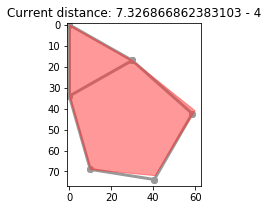

[[0.0, 0.0]]
[0.0, 0.0] [0.0, 0.0]
[[0.0, 0.0]]
[0.0, 34.0] [0.0, 0.0]
[[0.0, 0.0]]
[10.0, 69.0] [0.0, 0.0]
[[0.0, 0.0]]
[30.0, 17.0] [0.0, 0.0]
[[0.45753584909922296, -1.8301433963968918]]
[40.54246415090078, 73.83014339639689] [0.45753584909922296, -1.8301433963968918]
[[1.3726075472976618, -1.3726075472976618]]
[58.62739245270234, 42.37260754729766] [1.3726075472976618, -1.3726075472976618]


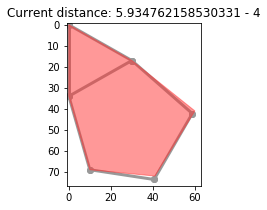

[[0.0, 0.0]]
[0.0, 0.0] [0.0, 0.0]
[[0.0, 0.0]]
[0.0, 34.0] [0.0, 0.0]
[[0.0, 0.0]]
[10.0, 69.0] [0.0, 0.0]
[[0.0, 0.0]]
[30.0, 17.0] [0.0, 0.0]
[[0.41178226418929853, -1.6471290567572083]]
[40.5882177358107, 73.64712905675721] [0.41178226418929853, -1.6471290567572083]
[[1.2353467925678956, -1.2353467925678956]]
[58.764653207432104, 42.235346792567896] [1.2353467925678956, -1.2353467925678956]


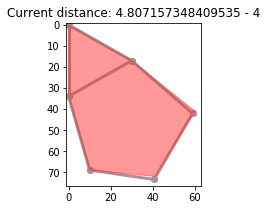

[[0.0, 0.0]]
[0.0, 0.0] [0.0, 0.0]
[[0.0, 0.0]]
[0.0, 34.0] [0.0, 0.0]
[[0.0, 0.0]]
[10.0, 69.0] [0.0, 0.0]
[[0.0, 0.0]]
[30.0, 17.0] [0.0, 0.0]
[[0.3706040377703701, -1.4824161510814804]]
[40.62939596222963, 73.48241615108148] [0.3706040377703701, -1.4824161510814804]
[[1.1118121133111032, -1.1118121133111032]]
[58.8881878866889, 42.1118121133111] [1.1118121133111032, -1.1118121133111032]


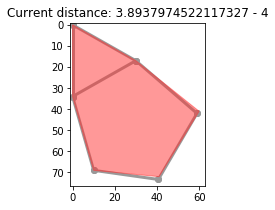

[[0.0, 0.0]]
[0.0, 0.0] [0.0, 0.0]
[[0.0, 0.0]]
[0.0, 34.0] [0.0, 0.0]
[[0.0, 0.0]]
[10.0, 69.0] [0.0, 0.0]
[[0.0, 0.0]]
[30.0, 17.0] [0.0, 0.0]
[[0.33354363399332954, -1.3341745359733324]]
[40.66645636600667, 73.33417453597333] [0.33354363399332954, -1.3341745359733324]
[[1.0006309019799957, -1.0006309019799957]]
[58.999369098020004, 42.000630901979996] [1.0006309019799957, -1.0006309019799957]


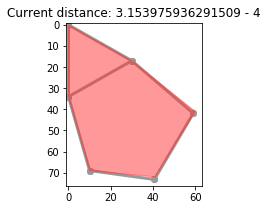

[[0.0, 0.0]]
[0.0, 0.0] [0.0, 0.0]
[[0.0, 0.0]]
[0.0, 34.0] [0.0, 0.0]
[[0.0, 0.0]]
[10.0, 69.0] [0.0, 0.0]
[[0.0, 0.0]]
[30.0, 17.0] [0.0, 0.0]
[[0.3001892705939966, -1.2007570823760005]]
[40.699810729406, 73.200757082376] [0.3001892705939966, -1.2007570823760005]
[[0.9005678117819969, -0.9005678117819969]]
[59.099432188218, 41.900567811782] [0.9005678117819969, -0.9005678117819969]


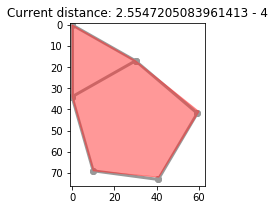

[[0.0, 0.0]]
[0.0, 0.0] [0.0, 0.0]
[[0.0, 0.0]]
[0.0, 34.0] [0.0, 0.0]
[[0.0, 0.0]]
[10.0, 69.0] [0.0, 0.0]
[[0.0, 0.0]]
[30.0, 17.0] [0.0, 0.0]
[[0.2701703435345948, -1.0806813741384076]]
[40.729829656465405, 73.08068137413841] [0.2701703435345948, -1.0806813741384076]
[[0.8105110306037986, -0.8105110306037986]]
[59.1894889693962, 41.8105110306038] [0.8105110306037986, -0.8105110306037986]


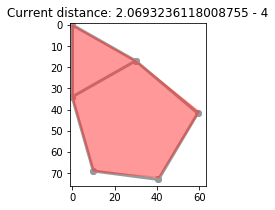

[[0.0, 0.0]]
[0.0, 0.0] [0.0, 0.0]
[[0.0, 0.0]]
[0.0, 34.0] [0.0, 0.0]
[[0.0, 0.0]]
[10.0, 69.0] [0.0, 0.0]
[[0.0, 0.0]]
[30.0, 17.0] [0.0, 0.0]
[[0.24315330918113887, -0.9726132367245697]]
[40.75684669081886, 72.97261323672457] [0.24315330918113887, -0.9726132367245697]
[[0.7294599275434166, -0.7294599275434166]]
[59.27054007245658, 41.72945992754342] [0.7294599275434166, -0.7294599275434166]


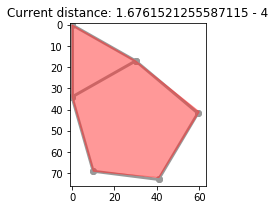

[[0.0, 0.0]]
[0.0, 0.0] [0.0, 0.0]
[[0.0, 0.0]]
[0.0, 34.0] [0.0, 0.0]
[[0.0, 0.0]]
[10.0, 69.0] [0.0, 0.0]
[[0.0, 0.0]]
[30.0, 17.0] [0.0, 0.0]
[[0.21883797826302498, -0.8753519130521141]]
[40.781162021736975, 72.87535191305211] [0.21883797826302498, -0.8753519130521141]
[[0.6565139347890749, -0.6565139347890749]]
[59.343486065210925, 41.656513934789075] [0.6565139347890749, -0.6565139347890749]


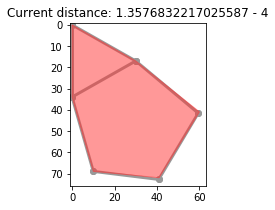

[[0.0, 0.0]]
[0.0, 0.0] [0.0, 0.0]
[[0.0, 0.0]]
[0.0, 34.0] [0.0, 0.0]
[[0.0, 0.0]]
[10.0, 69.0] [0.0, 0.0]
[[0.0, 0.0]]
[30.0, 17.0] [0.0, 0.0]
[[0.19695418043671964, -0.787816721746907]]
[40.80304581956328, 72.7878167217469] [0.19695418043671964, -0.787816721746907]
[[0.590862541310166, -0.590862541310166]]
[59.409137458689834, 41.590862541310166] [0.590862541310166, -0.590862541310166]


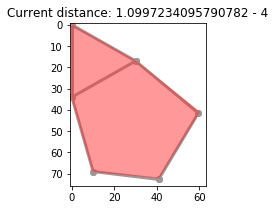

[[0.0, 0.0]]
[0.0, 0.0] [0.0, 0.0]
[[0.0, 0.0]]
[0.0, 34.0] [0.0, 0.0]
[[0.0, 0.0]]
[10.0, 69.0] [0.0, 0.0]
[[0.0, 0.0]]
[30.0, 17.0] [0.0, 0.0]
[[0.17725876239304483, -0.709035049572222]]
[40.822741237606955, 72.70903504957222] [0.17725876239304483, -0.709035049572222]
[[0.5317762871791487, -0.5317762871791487]]
[59.46822371282085, 41.53177628717915] [0.5317762871791487, -0.5317762871791487]


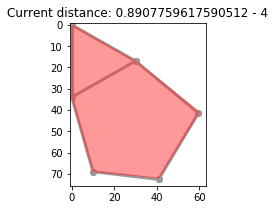

[[0.0, 0.0]]
[0.0, 0.0] [0.0, 0.0]
[[0.0, 0.0]]
[0.0, 34.0] [0.0, 0.0]
[[0.0, 0.0]]
[10.0, 69.0] [0.0, 0.0]
[[0.0, 0.0]]
[30.0, 17.0] [0.0, 0.0]
[[0.15953288615374106, -0.6381315446149927]]
[40.84046711384626, 72.63813154461499] [0.15953288615374106, -0.6381315446149927]
[[0.4785986584612374, -0.4785986584612374]]
[59.52140134153876, 41.47859865846124] [0.4785986584612374, -0.4785986584612374]


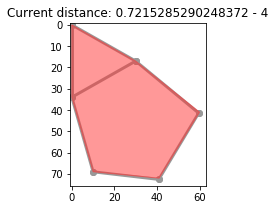

[[0.0, 0.0]]
[0.0, 0.0] [0.0, 0.0]
[[0.0, 0.0]]
[0.0, 34.0] [0.0, 0.0]
[[0.0, 0.0]]
[10.0, 69.0] [0.0, 0.0]
[[0.0, 0.0]]
[30.0, 17.0] [0.0, 0.0]
[[0.1435795975383698, -0.5743183901534934]]
[40.85642040246163, 72.5743183901535] [0.1435795975383698, -0.5743183901534934]
[[0.4307387926151165, -0.4307387926151165]]
[59.56926120738488, 41.43073879261512] [0.4307387926151165, -0.4307387926151165]


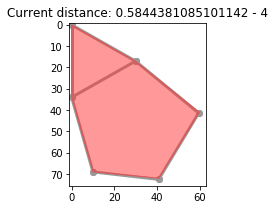

[[0.0, 0.0]]
[0.0, 0.0] [0.0, 0.0]
[[0.0, 0.0]]
[0.0, 34.0] [0.0, 0.0]
[[0.0, 0.0]]
[10.0, 69.0] [0.0, 0.0]
[[0.0, 0.0]]
[30.0, 17.0] [0.0, 0.0]
[[0.1292216377845321, -0.5168865511381426]]
[40.87077836221547, 72.51688655113814] [0.1292216377845321, -0.5168865511381426]
[[0.3876649133536034, -0.3876649133536034]]
[59.6123350866464, 41.3876649133536] [0.3876649133536034, -0.3876649133536034]


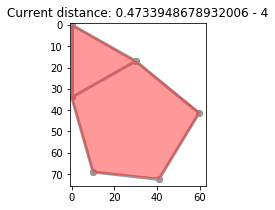

[[0.0, 0.0]]
[0.0, 0.0] [0.0, 0.0]
[[0.0, 0.0]]
[0.0, 34.0] [0.0, 0.0]
[[0.0, 0.0]]
[10.0, 69.0] [0.0, 0.0]
[[0.0, 0.0]]
[30.0, 17.0] [0.0, 0.0]
[[0.11629947400607676, -0.4651978960243355]]
[40.88370052599392, 72.46519789602434] [0.11629947400607676, -0.4651978960243355]
[[0.3488984220182445, -0.3488984220182445]]
[59.651101577981755, 41.348898422018245] [0.3488984220182445, -0.3488984220182445]


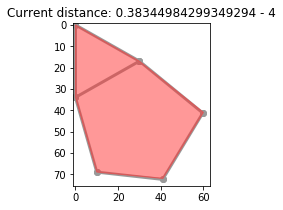

[[0.0, 0.0]]
[0.0, 0.0] [0.0, 0.0]
[[0.0, 0.0]]
[0.0, 34.0] [0.0, 0.0]
[[0.0, 0.0]]
[10.0, 69.0] [0.0, 0.0]
[[0.0, 0.0]]
[30.0, 17.0] [0.0, 0.0]
[[0.1046695266054698, -0.4186781064219076]]
[40.89533047339453, 72.41867810642191] [0.1046695266054698, -0.4186781064219076]
[[0.3140085798164165, -0.3140085798164165]]
[59.68599142018358, 41.31400857981642] [0.3140085798164165, -0.3140085798164165]


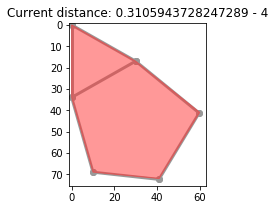

[[0.0, 0.0]]
[0.0, 0.0] [0.0, 0.0]
[[0.0, 0.0]]
[0.0, 34.0] [0.0, 0.0]
[[0.0, 0.0]]
[10.0, 69.0] [0.0, 0.0]
[[0.0, 0.0]]
[30.0, 17.0] [0.0, 0.0]
[[0.09420257394492637, -0.3768102957797197]]
[40.905797426055074, 72.37681029577972] [0.09420257394492637, -0.3768102957797197]
[[0.282607721834772, -0.282607721834772]]
[59.71739227816523, 41.28260772183477] [0.282607721834772, -0.282607721834772]


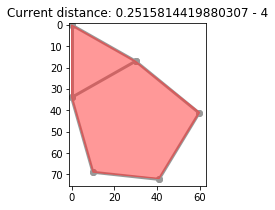

[[0.0, 0.0]]
[0.0, 0.0] [0.0, 0.0]
[[0.0, 0.0]]
[0.0, 34.0] [0.0, 0.0]
[[0.0, 0.0]]
[10.0, 69.0] [0.0, 0.0]
[[0.0, 0.0]]
[30.0, 17.0] [0.0, 0.0]
[[0.08478231655043089, -0.339129266201752]]
[40.91521768344957, 72.33912926620175] [0.08478231655043089, -0.339129266201752]
[[0.2543469496512927, -0.2543469496512927]]
[59.74565305034871, 41.25434694965129] [0.2543469496512927, -0.2543469496512927]


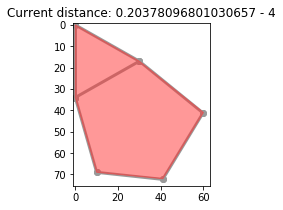

[[0.0, 0.0]]
[0.0, 0.0] [0.0, 0.0]
[[0.0, 0.0]]
[0.0, 34.0] [0.0, 0.0]
[[0.0, 0.0]]
[10.0, 69.0] [0.0, 0.0]
[[0.0, 0.0]]
[30.0, 17.0] [0.0, 0.0]
[[0.07630408489539064, -0.3052163395815768]]
[40.92369591510461, 72.30521633958158] [0.07630408489539064, -0.3052163395815768]
[[0.22891225468616483, -0.22891225468616483]]
[59.771087745313835, 41.228912254686165] [0.22891225468616483, -0.22891225468616483]


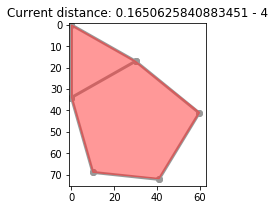

[[0.0, 0.0]]
[0.0, 0.0] [0.0, 0.0]
[[0.0, 0.0]]
[0.0, 34.0] [0.0, 0.0]
[[0.0, 0.0]]
[10.0, 69.0] [0.0, 0.0]
[[0.0, 0.0]]
[30.0, 17.0] [0.0, 0.0]
[[0.06867367640585087, -0.2746947056234177]]
[40.93132632359415, 72.27469470562342] [0.06867367640585087, -0.2746947056234177]
[[0.2060210292175455, -0.2060210292175455]]
[59.793978970782454, 41.206021029217546] [0.2060210292175455, -0.2060210292175455]


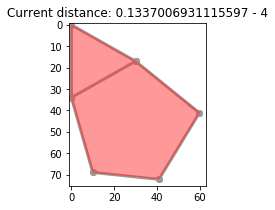

[[0.0, 0.0]]
[0.0, 0.0] [0.0, 0.0]
[[0.0, 0.0]]
[0.0, 34.0] [0.0, 0.0]
[[0.0, 0.0]]
[10.0, 69.0] [0.0, 0.0]
[[0.0, 0.0]]
[30.0, 17.0] [0.0, 0.0]
[[0.06180630876526294, -0.24722523506108018]]
[40.93819369123474, 72.24722523506108] [0.06180630876526294, -0.24722523506108018]
[[0.18541892629578882, -0.18541892629578882]]
[59.81458107370421, 41.18541892629579] [0.18541892629578882, -0.18541892629578882]


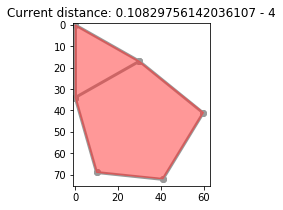

[[0.0, 0.0]]
[0.0, 0.0] [0.0, 0.0]
[[0.0, 0.0]]
[0.0, 34.0] [0.0, 0.0]
[[0.0, 0.0]]
[10.0, 69.0] [0.0, 0.0]
[[0.0, 0.0]]
[30.0, 17.0] [0.0, 0.0]
[[0.055625677888734515, -0.22250271155496648]]
[40.944374322111265, 72.22250271155497] [0.055625677888734515, -0.22250271155496648]
[[0.16687703366621065, -0.16687703366621065]]
[59.83312296633379, 41.16687703366621] [0.16687703366621065, -0.16687703366621065]


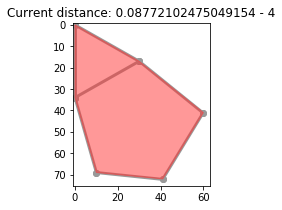

[[0.0, 0.0]]
[0.0, 0.0] [0.0, 0.0]
[[0.0, 0.0]]
[0.0, 34.0] [0.0, 0.0]
[[0.0, 0.0]]
[10.0, 69.0] [0.0, 0.0]
[[0.0, 0.0]]
[30.0, 17.0] [0.0, 0.0]
[[0.050063110099863195, -0.200252440399467]]
[40.94993688990014, 72.20025244039947] [0.050063110099863195, -0.200252440399467]
[[0.15018933029958959, -0.15018933029958959]]
[59.84981066970041, 41.15018933029959] [0.15018933029958959, -0.15018933029958959]


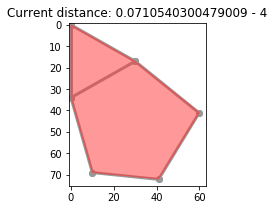

[[0.0, 0.0]]
[0.0, 0.0] [0.0, 0.0]
[[0.0, 0.0]]
[0.0, 34.0] [0.0, 0.0]
[[0.0, 0.0]]
[10.0, 69.0] [0.0, 0.0]
[[0.0, 0.0]]
[30.0, 17.0] [0.0, 0.0]
[[0.045056799089877586, -0.18022719635952456]]
[40.95494320091012, 72.18022719635952] [0.045056799089877586, -0.18022719635952456]
[[0.13517039726963276, -0.13517039726963276]]
[59.86482960273037, 41.13517039726963] [0.13517039726963276, -0.13517039726963276]


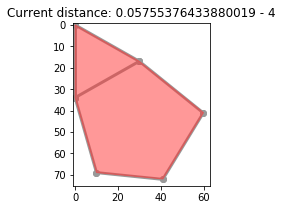

[[0.0, 0.0]]
[0.0, 0.0] [0.0, 0.0]
[[0.0, 0.0]]
[0.0, 34.0] [0.0, 0.0]
[[0.0, 0.0]]
[10.0, 69.0] [0.0, 0.0]
[[0.0, 0.0]]
[30.0, 17.0] [0.0, 0.0]
[[0.04055111918088983, -0.16220447672357352]]
[40.95944888081911, 72.16220447672357] [0.04055111918088983, -0.16220447672357352]
[[0.12165335754266948, -0.12165335754266948]]
[59.87834664245733, 41.12165335754267] [0.12165335754266948, -0.12165335754266948]


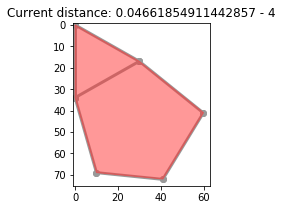

[[0.0, 0.0]]
[0.0, 0.0] [0.0, 0.0]
[[0.0, 0.0]]
[0.0, 34.0] [0.0, 0.0]
[[0.0, 0.0]]
[10.0, 69.0] [0.0, 0.0]
[[0.0, 0.0]]
[30.0, 17.0] [0.0, 0.0]
[[0.036496007262798, -0.14598402905122043]]
[40.9635039927372, 72.14598402905122] [0.036496007262798, -0.14598402905122043]
[[0.10948802178840111, -0.10948802178840111]]
[59.8905119782116, 41.1094880217884] [0.10948802178840111, -0.10948802178840111]


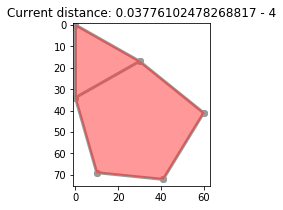

[[0.0, 0.0]]
[0.0, 0.0] [0.0, 0.0]
[[0.0, 0.0]]
[0.0, 34.0] [0.0, 0.0]
[[0.0, 0.0]]
[10.0, 69.0] [0.0, 0.0]
[[0.0, 0.0]]
[30.0, 17.0] [0.0, 0.0]
[[0.032846406536521044, -0.1313856261460984]]
[40.96715359346348, 72.1313856261461] [0.032846406536521044, -0.1313856261460984]
[[0.09853921960956313, -0.09853921960956313]]
[59.90146078039044, 41.09853921960956] [0.09853921960956313, -0.09853921960956313]


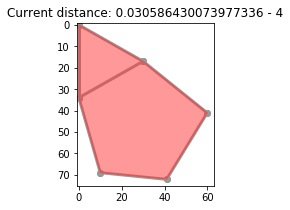

[[0.0, 0.0]]
[0.0, 0.0] [0.0, 0.0]
[[0.0, 0.0]]
[0.0, 34.0] [0.0, 0.0]
[[0.0, 0.0]]
[10.0, 69.0] [0.0, 0.0]
[[0.0, 0.0]]
[30.0, 17.0] [0.0, 0.0]
[[0.02956176588286752, -0.11824706353148429]]
[40.97043823411713, 72.11824706353148] [0.02956176588286752, -0.11824706353148429]
[[0.08868529764860966, -0.08868529764860966]]
[59.91131470235139, 41.08868529764861] [0.08868529764860966, -0.08868529764860966]


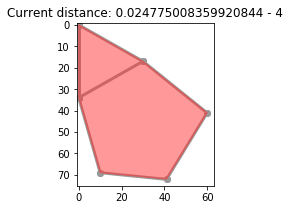

[[0.0, 0.0]]
[0.0, 0.0] [0.0, 0.0]
[[0.0, 0.0]]
[0.0, 34.0] [0.0, 0.0]
[[0.0, 0.0]]
[10.0, 69.0] [0.0, 0.0]
[[0.0, 0.0]]
[30.0, 17.0] [0.0, 0.0]
[[0.0266055892945829, -0.1064223571783316]]
[40.97339441070542, 72.10642235717833] [0.0266055892945829, -0.1064223571783316]
[[0.0798167678837487, -0.0798167678837487]]
[59.92018323211625, 41.07981676788375] [0.0798167678837487, -0.0798167678837487]


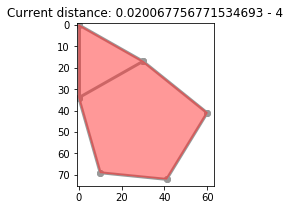

[[0.0, 0.0]]
[0.0, 0.0] [0.0, 0.0]
[[0.0, 0.0]]
[0.0, 34.0] [0.0, 0.0]
[[0.0, 0.0]]
[10.0, 69.0] [0.0, 0.0]
[[0.0, 0.0]]
[30.0, 17.0] [0.0, 0.0]
[[0.02394503036512674, -0.09578012146049275]]
[40.97605496963487, 72.09578012146049] [0.02394503036512674, -0.09578012146049275]
[[0.07183509109537312, -0.07183509109537312]]
[59.92816490890463, 41.07183509109537] [0.07183509109537312, -0.07183509109537312]


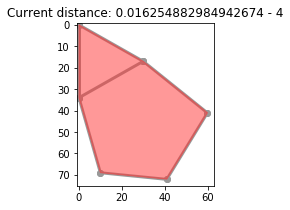

[[0.0, 0.0]]
[0.0, 0.0] [0.0, 0.0]
[[0.0, 0.0]]
[0.0, 34.0] [0.0, 0.0]
[[0.0, 0.0]]
[10.0, 69.0] [0.0, 0.0]
[[0.0, 0.0]]
[30.0, 17.0] [0.0, 0.0]
[[0.021550527328614066, -0.08620210931444205]]
[40.978449472671386, 72.08620210931444] [0.021550527328614066, -0.08620210931444205]
[[0.0646515819858351, -0.0646515819858351]]
[59.935348418014165, 41.064651581985835] [0.0646515819858351, -0.0646515819858351]


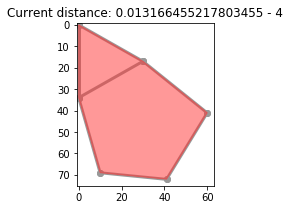

[[0.0, 0.0]]
[0.0, 0.0] [0.0, 0.0]
[[0.0, 0.0]]
[0.0, 34.0] [0.0, 0.0]
[[0.0, 0.0]]
[10.0, 69.0] [0.0, 0.0]
[[0.0, 0.0]]
[30.0, 17.0] [0.0, 0.0]
[[0.01939547459575408, -0.07758189838300211]]
[40.980604525404246, 72.077581898383] [0.01939547459575408, -0.07758189838300211]
[[0.05818642378724803, -0.05818642378724803]]
[59.94181357621275, 41.05818642378725] [0.05818642378724803, -0.05818642378724803]


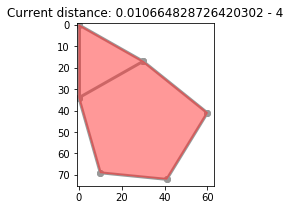

[[0.0, 0.0]]
[0.0, 0.0] [0.0, 0.0]
[[0.0, 0.0]]
[0.0, 34.0] [0.0, 0.0]
[[0.0, 0.0]]
[10.0, 69.0] [0.0, 0.0]
[[0.0, 0.0]]
[30.0, 17.0] [0.0, 0.0]
[[0.01745592713617583, -0.06982370854470332]]
[40.982544072863824, 72.0698237085447] [0.01745592713617583, -0.06982370854470332]
[[0.052367781408520386, -0.052367781408520386]]
[59.94763221859148, 41.05236778140852] [0.052367781408520386, -0.052367781408520386]


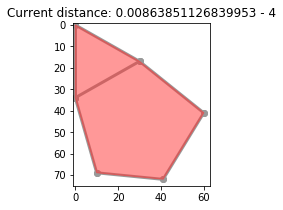

[[0.0, 0.0]]
[0.0, 0.0] [0.0, 0.0]
[[0.0, 0.0]]
[0.0, 34.0] [0.0, 0.0]
[[0.0, 0.0]]
[10.0, 69.0] [0.0, 0.0]
[[0.0, 0.0]]
[30.0, 17.0] [0.0, 0.0]
[[0.015710334422557537, -0.06284133769023015]]
[40.98428966557744, 72.06284133769023] [0.015710334422557537, -0.06284133769023015]
[[0.047131003267665506, -0.047131003267665506]]
[59.952868996732334, 41.047131003267666] [0.047131003267665506, -0.047131003267665506]


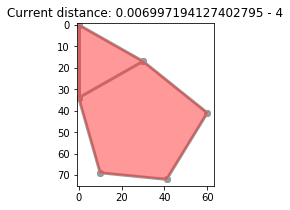

[[0.0, 0.0]]
[0.0, 0.0] [0.0, 0.0]
[[0.0, 0.0]]
[0.0, 34.0] [0.0, 0.0]
[[0.0, 0.0]]
[10.0, 69.0] [0.0, 0.0]
[[0.0, 0.0]]
[30.0, 17.0] [0.0, 0.0]
[[0.014139300980303915, -0.05655720392120145]]
[40.985860699019696, 72.0565572039212] [0.014139300980303915, -0.05655720392120145]
[[0.042417902940897534, -0.042417902940897534]]
[59.9575820970591, 41.0424179029409] [0.042417902940897534, -0.042417902940897534]


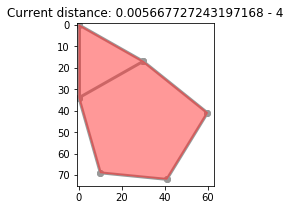

[[0.0, 0.0]]
[0.0, 0.0] [0.0, 0.0]
[[0.0, 0.0]]
[0.0, 34.0] [0.0, 0.0]
[[0.0, 0.0]]
[10.0, 69.0] [0.0, 0.0]
[[0.0, 0.0]]
[30.0, 17.0] [0.0, 0.0]
[[0.012725370882272102, -0.05090148352908841]]
[40.98727462911773, 72.05090148352909] [0.012725370882272102, -0.05090148352908841]
[[0.0381761126468092, -0.0381761126468092]]
[59.96182388735319, 41.03817611264681] [0.0381761126468092, -0.0381761126468092]


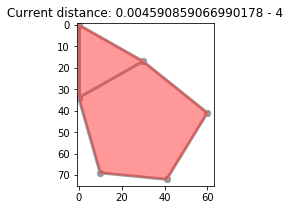

[[0.0, 0.0]]
[0.0, 0.0] [0.0, 0.0]
[[0.0, 0.0]]
[0.0, 34.0] [0.0, 0.0]
[[0.0, 0.0]]
[10.0, 69.0] [0.0, 0.0]
[[0.0, 0.0]]
[30.0, 17.0] [0.0, 0.0]
[[0.011452833794045603, -0.04581133517618241]]
[40.988547166205954, 72.04581133517618] [0.011452833794045603, -0.04581133517618241]
[[0.0343585013821297, -0.0343585013821297]]
[59.96564149861787, 41.03435850138213] [0.0343585013821297, -0.0343585013821297]


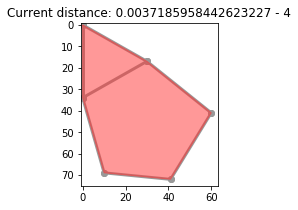

[[0.0, 0.0]]
[0.0, 0.0] [0.0, 0.0]
[[0.0, 0.0]]
[0.0, 34.0] [0.0, 0.0]
[[0.0, 0.0]]
[10.0, 69.0] [0.0, 0.0]
[[0.0, 0.0]]
[30.0, 17.0] [0.0, 0.0]
[[0.01030755041463749, -0.04123020165856417]]
[40.98969244958536, 72.04123020165856] [0.01030755041463749, -0.04123020165856417]
[[0.030922651243919574, -0.030922651243919574]]
[59.96907734875608, 41.03092265124392] [0.030922651243919574, -0.030922651243919574]


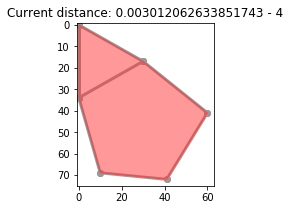

[[0.0, 0.0]]
[0.0, 0.0] [0.0, 0.0]
[[0.0, 0.0]]
[0.0, 34.0] [0.0, 0.0]
[[0.0, 0.0]]
[10.0, 69.0] [0.0, 0.0]
[[0.0, 0.0]]
[30.0, 17.0] [0.0, 0.0]
[[0.009276795373175162, -0.03710718149270065]]
[40.990723204626825, 72.0371071814927] [0.009276795373175162, -0.03710718149270065]
[[0.027830386119525485, -0.027830386119525485]]
[59.972169613880475, 41.027830386119525] [0.027830386119525485, -0.027830386119525485]


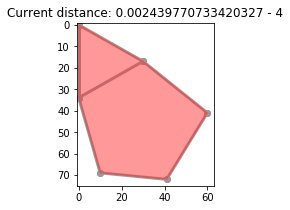

[[0.0, 0.0]]
[0.0, 0.0] [0.0, 0.0]
[[0.0, 0.0]]
[0.0, 34.0] [0.0, 0.0]
[[0.0, 0.0]]
[10.0, 69.0] [0.0, 0.0]
[[0.0, 0.0]]
[30.0, 17.0] [0.0, 0.0]
[[0.008349115835855514, -0.03339646334343627]]
[40.991650884164144, 72.03339646334344] [0.008349115835855514, -0.03339646334343627]
[[0.025047347507573647, -0.025047347507573647]]
[59.974952652492426, 41.025047347507574] [0.025047347507573647, -0.025047347507573647]


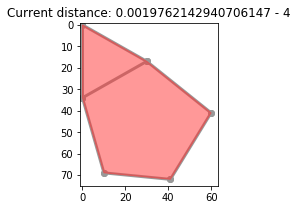

[[0.0, 0.0]]
[0.0, 0.0] [0.0, 0.0]
[[0.0, 0.0]]
[0.0, 34.0] [0.0, 0.0]
[[0.0, 0.0]]
[10.0, 69.0] [0.0, 0.0]
[[0.0, 0.0]]
[30.0, 17.0] [0.0, 0.0]
[[0.00751420425226712, -0.030056817009096903]]
[40.99248579574773, 72.0300568170091] [0.00751420425226712, -0.030056817009096903]
[[0.022542612756815572, -0.022542612756815572]]
[59.977457387243184, 41.022542612756816] [0.022542612756815572, -0.022542612756815572]


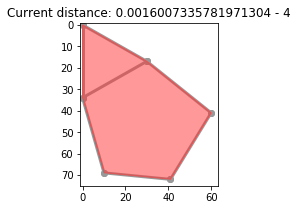

[[0.0, 0.0]]
[0.0, 0.0] [0.0, 0.0]
[[0.0, 0.0]]
[0.0, 34.0] [0.0, 0.0]
[[0.0, 0.0]]
[10.0, 69.0] [0.0, 0.0]
[[0.0, 0.0]]
[30.0, 17.0] [0.0, 0.0]
[[0.00676278382704254, -0.02705113530818437]]
[40.99323721617296, 72.02705113530818] [0.00676278382704254, -0.02705113530818437]
[[0.020288351481134725, -0.020288351481134725]]
[59.979711648518865, 41.020288351481135] [0.020288351481134725, -0.020288351481134725]


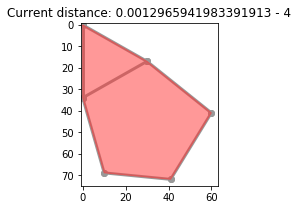

[[0.0, 0.0]]
[0.0, 0.0] [0.0, 0.0]
[[0.0, 0.0]]
[0.0, 34.0] [0.0, 0.0]
[[0.0, 0.0]]
[10.0, 69.0] [0.0, 0.0]
[[0.0, 0.0]]
[30.0, 17.0] [0.0, 0.0]
[[0.006086505444336865, -0.02434602177736167]]
[40.99391349455566, 72.02434602177736] [0.006086505444336865, -0.02434602177736167]
[[0.0182595163330177, -0.0182595163330177]]
[59.98174048366698, 41.01825951633302] [0.0182595163330177, -0.0182595163330177]


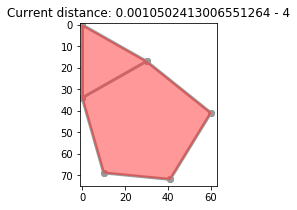

[[0.0, 0.0]]
[0.0, 0.0] [0.0, 0.0]
[[0.0, 0.0]]
[0.0, 34.0] [0.0, 0.0]
[[0.0, 0.0]]
[10.0, 69.0] [0.0, 0.0]
[[0.0, 0.0]]
[30.0, 17.0] [0.0, 0.0]
[[0.005477854899901047, -0.02191141959963261]]
[40.9945221451001, 72.02191141959963] [0.005477854899901047, -0.02191141959963261]
[[0.01643356469971735, -0.01643356469971735]]
[59.98356643530028, 41.01643356469972] [0.01643356469971735, -0.01643356469971735]


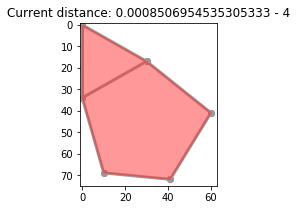

[[0.0, 0.0]]
[0.0, 0.0] [0.0, 0.0]
[[0.0, 0.0]]
[0.0, 34.0] [0.0, 0.0]
[[0.0, 0.0]]
[10.0, 69.0] [0.0, 0.0]
[[0.0, 0.0]]
[30.0, 17.0] [0.0, 0.0]
[[0.0049300694099088105, -0.019720277639663664]]
[40.99506993059009, 72.01972027763966] [0.0049300694099088105, -0.019720277639663664]
[[0.014790208229747748, -0.014790208229747748]]
[59.98520979177025, 41.01479020822975] [0.014790208229747748, -0.014790208229747748]


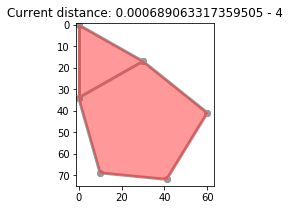

[[0.0, 0.0]]
[0.0, 0.0] [0.0, 0.0]
[[0.0, 0.0]]
[0.0, 34.0] [0.0, 0.0]
[[0.0, 0.0]]
[10.0, 69.0] [0.0, 0.0]
[[0.0, 0.0]]
[30.0, 17.0] [0.0, 0.0]
[[0.004437062468916508, -0.017748249875694455]]
[40.99556293753108, 72.0177482498757] [0.004437062468916508, -0.017748249875694455]
[[0.013311187406770841, -0.013311187406770841]]
[59.98668881259323, 41.01331118740677] [0.013311187406770841, -0.013311187406770841]


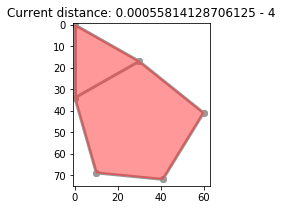

[[0.0, 0.0]]
[0.0, 0.0] [0.0, 0.0]
[[0.0, 0.0]]
[0.0, 34.0] [0.0, 0.0]
[[0.0, 0.0]]
[10.0, 69.0] [0.0, 0.0]
[[0.0, 0.0]]
[30.0, 17.0] [0.0, 0.0]
[[0.003993356222025568, -0.015973424888130694]]
[40.996006643777974, 72.01597342488813] [0.003993356222025568, -0.015973424888130694]
[[0.011980068666090915, -0.011980068666090915]]
[59.98801993133391, 41.01198006866609] [0.011980068666090915, -0.011980068666090915]


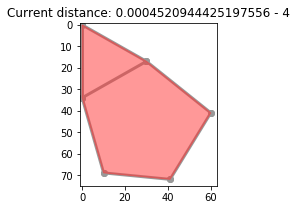

[[0.0, 0.0]]
[0.0, 0.0] [0.0, 0.0]
[[0.0, 0.0]]
[0.0, 34.0] [0.0, 0.0]
[[0.0, 0.0]]
[10.0, 69.0] [0.0, 0.0]
[[0.0, 0.0]]
[30.0, 17.0] [0.0, 0.0]
[[0.003594020599820169, -0.014376082399323309]]
[40.99640597940018, 72.01437608239932] [0.003594020599820169, -0.014376082399323309]
[[0.010782061799481824, -0.010782061799481824]]
[59.98921793820052, 41.01078206179948] [0.010782061799481824, -0.010782061799481824]


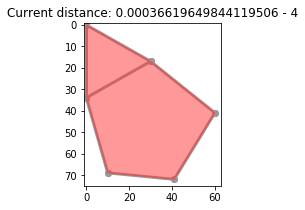

[[0.0, 0.0]]
[0.0, 0.0] [0.0, 0.0]
[[0.0, 0.0]]
[0.0, 34.0] [0.0, 0.0]
[[0.0, 0.0]]
[10.0, 69.0] [0.0, 0.0]
[[0.0, 0.0]]
[30.0, 17.0] [0.0, 0.0]
[[0.00323461853983531, -0.012938474159398083]]
[40.996765381460165, 72.0129384741594] [0.00323461853983531, -0.012938474159398083]
[[0.009703855619534352, -0.009703855619534352]]
[59.990296144380466, 41.009703855619534] [0.009703855619534352, -0.009703855619534352]


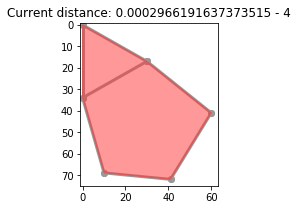

[[0.0, 0.0]]
[0.0, 0.0] [0.0, 0.0]
[[0.0, 0.0]]
[0.0, 34.0] [0.0, 0.0]
[[0.0, 0.0]]
[10.0, 69.0] [0.0, 0.0]
[[0.0, 0.0]]
[30.0, 17.0] [0.0, 0.0]
[[0.002911156685854621, -0.011644626743461117]]
[40.997088843314145, 72.01164462674346] [0.002911156685854621, -0.011644626743461117]
[[0.008733470057578074, -0.008733470057578074]]
[59.99126652994242, 41.00873347005758] [0.008733470057578074, -0.008733470057578074]


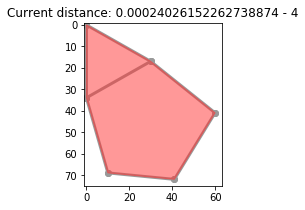

[[0.0, 0.0]]
[0.0, 0.0] [0.0, 0.0]
[[0.0, 0.0]]
[0.0, 34.0] [0.0, 0.0]
[[0.0, 0.0]]
[10.0, 69.0] [0.0, 0.0]
[[0.0, 0.0]]
[30.0, 17.0] [0.0, 0.0]
[[0.002620041017266317, -0.010480164069122111]]
[40.997379958982734, 72.01048016406912] [0.002620041017266317, -0.010480164069122111]
[[0.007860123051820267, -0.007860123051820267]]
[59.99213987694818, 41.00786012305182] [0.007860123051820267, -0.007860123051820267]


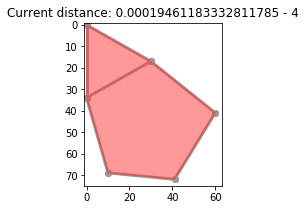

[[0.0, 0.0]]
[0.0, 0.0] [0.0, 0.0]
[[0.0, 0.0]]
[0.0, 34.0] [0.0, 0.0]
[[0.0, 0.0]]
[10.0, 69.0] [0.0, 0.0]
[[0.0, 0.0]]
[30.0, 17.0] [0.0, 0.0]
[[0.002358036915538264, -0.0094321476622099]]
[40.99764196308446, 72.00943214766221] [0.002358036915538264, -0.0094321476622099]
[[0.007074110746636109, -0.007074110746636109]]
[59.992925889253364, 41.007074110746636] [0.007074110746636109, -0.007074110746636109]


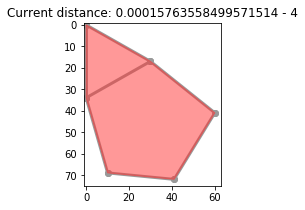

[[0.0, 0.0]]
[0.0, 0.0] [0.0, 0.0]
[[0.0, 0.0]]
[0.0, 34.0] [0.0, 0.0]
[[0.0, 0.0]]
[10.0, 69.0] [0.0, 0.0]
[[0.0, 0.0]]
[30.0, 17.0] [0.0, 0.0]
[[0.002122233223985859, -0.008488932895986068]]
[40.997877766776014, 72.00848893289599] [0.002122233223985859, -0.008488932895986068]
[[0.006366699671971787, -0.006366699671971787]]
[59.99363330032803, 41.00636669967197] [0.006366699671971787, -0.006366699671971787]


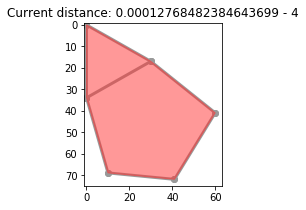

[[0.0, 0.0]]
[0.0, 0.0] [0.0, 0.0]
[[0.0, 0.0]]
[0.0, 34.0] [0.0, 0.0]
[[0.0, 0.0]]
[10.0, 69.0] [0.0, 0.0]
[[0.0, 0.0]]
[30.0, 17.0] [0.0, 0.0]
[[0.0019100099015858518, -0.00764003960638604]]
[40.998089990098414, 72.00764003960639] [0.0019100099015858518, -0.00764003960638604]
[[0.005730029704771766, -0.005730029704771766]]
[59.99426997029523, 41.00573002970477] [0.005730029704771766, -0.005730029704771766]


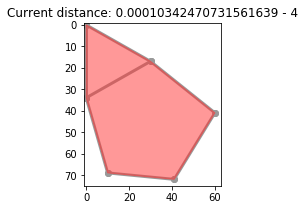

[[0.0, 0.0]]
[0.0, 0.0] [0.0, 0.0]
[[0.0, 0.0]]
[0.0, 34.0] [0.0, 0.0]
[[0.0, 0.0]]
[10.0, 69.0] [0.0, 0.0]
[[0.0, 0.0]]
[30.0, 17.0] [0.0, 0.0]
[[0.0017190089114293983, -0.006876035645746015]]
[40.99828099108857, 72.00687603564575] [0.0017190089114293983, -0.006876035645746015]
[[0.0051570267342953, -0.0051570267342953]]
[59.994842973265705, 41.005157026734295] [0.0051570267342953, -0.0051570267342953]


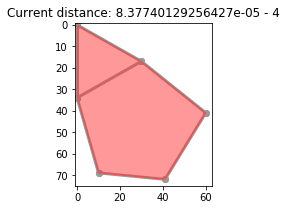

[[0.0, 0.0]]
[0.0, 0.0] [0.0, 0.0]
[[0.0, 0.0]]
[0.0, 34.0] [0.0, 0.0]
[[0.0, 0.0]]
[10.0, 69.0] [0.0, 0.0]
[[0.0, 0.0]]
[30.0, 17.0] [0.0, 0.0]
[[0.0015471080202900112, -0.0061884320811742555]]
[40.99845289197971, 72.00618843208117] [0.0015471080202900112, -0.0061884320811742555]
[[0.004641324060862928, -0.004641324060862928]]
[59.99535867593914, 41.00464132406086] [0.004641324060862928, -0.004641324060862928]


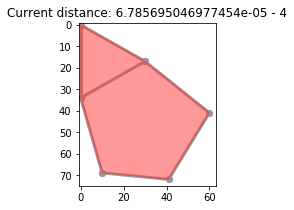

[[0.0, 0.0]]
[0.0, 0.0] [0.0, 0.0]
[[0.0, 0.0]]
[0.0, 34.0] [0.0, 0.0]
[[0.0, 0.0]]
[10.0, 69.0] [0.0, 0.0]
[[0.0, 0.0]]
[30.0, 17.0] [0.0, 0.0]
[[0.00139239721826101, -0.005569588873058251]]
[40.99860760278174, 72.00556958887306] [0.00139239721826101, -0.005569588873058251]
[[0.004177191654775925, -0.004177191654775925]]
[59.995822808345224, 41.004177191654776] [0.004177191654775925, -0.004177191654775925]


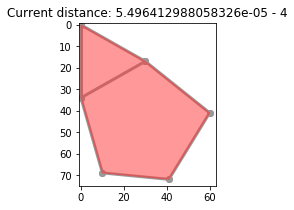

[[0.0, 0.0]]
[0.0, 0.0] [0.0, 0.0]
[[0.0, 0.0]]
[0.0, 34.0] [0.0, 0.0]
[[0.0, 0.0]]
[10.0, 69.0] [0.0, 0.0]
[[0.0, 0.0]]
[30.0, 17.0] [0.0, 0.0]
[[0.0012531574964356196, -0.005012629985756689]]
[40.998746842503564, 72.00501262998576] [0.0012531574964356196, -0.005012629985756689]
[[0.0037594724892997533, -0.0037594724892997533]]
[59.9962405275107, 41.0037594724893] [0.0037594724892997533, -0.0037594724892997533]


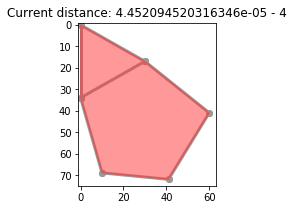

[[0.0, 0.0]]
[0.0, 0.0] [0.0, 0.0]
[[0.0, 0.0]]
[0.0, 34.0] [0.0, 0.0]
[[0.0, 0.0]]
[10.0, 69.0] [0.0, 0.0]
[[0.0, 0.0]]
[30.0, 17.0] [0.0, 0.0]
[[0.0011278417467934787, -0.004511366987173915]]
[40.99887215825321, 72.00451136698717] [0.0011278417467934787, -0.004511366987173915]
[[0.0033835252403662253, -0.0033835252403662253]]
[59.996616474759634, 41.003383525240366] [0.0033835252403662253, -0.0033835252403662253]


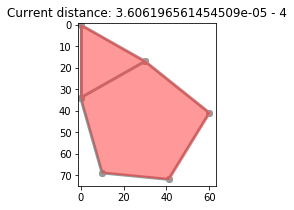

[[0.0, 0.0]]
[0.0, 0.0] [0.0, 0.0]
[[0.0, 0.0]]
[0.0, 34.0] [0.0, 0.0]
[[0.0, 0.0]]
[10.0, 69.0] [0.0, 0.0]
[[0.0, 0.0]]
[30.0, 17.0] [0.0, 0.0]
[[0.0010150575721112887, -0.0040602302884593655]]
[40.99898494242789, 72.00406023028846] [0.0010150575721112887, -0.0040602302884593655]
[[0.0030451727163267606, -0.0030451727163267606]]
[59.99695482728367, 41.00304517271633] [0.0030451727163267606, -0.0030451727163267606]


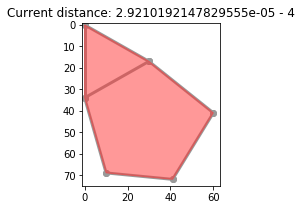

[[0.0, 0.0]]
[0.0, 0.0] [0.0, 0.0]
[[0.0, 0.0]]
[0.0, 34.0] [0.0, 0.0]
[[0.0, 0.0]]
[10.0, 69.0] [0.0, 0.0]
[[0.0, 0.0]]
[30.0, 17.0] [0.0, 0.0]
[[0.0009135518149037125, -0.00365420725961485]]
[40.999086448185096, 72.00365420725961] [0.0009135518149037125, -0.00365420725961485]
[[0.0027406554446969267, -0.0027406554446969267]]
[59.9972593445553, 41.0027406554447] [0.0027406554446969267, -0.0027406554446969267]


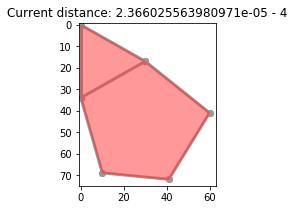

[[0.0, 0.0]]
[0.0, 0.0] [0.0, 0.0]
[[0.0, 0.0]]
[0.0, 34.0] [0.0, 0.0]
[[0.0, 0.0]]
[10.0, 69.0] [0.0, 0.0]
[[0.0, 0.0]]
[30.0, 17.0] [0.0, 0.0]
[[0.0008221966334147623, -0.0032887865336590494]]
[40.999177803366585, 72.00328878653366] [0.0008221966334147623, -0.0032887865336590494]
[[0.002466589900230076, -0.002466589900230076]]
[59.99753341009977, 41.00246658990023] [0.002466589900230076, -0.002466589900230076]


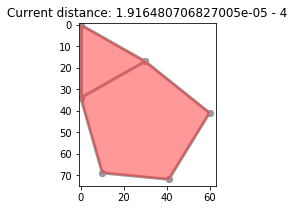

[[0.0, 0.0]]
[0.0, 0.0] [0.0, 0.0]
[[0.0, 0.0]]
[0.0, 34.0] [0.0, 0.0]
[[0.0, 0.0]]
[10.0, 69.0] [0.0, 0.0]
[[0.0, 0.0]]
[30.0, 17.0] [0.0, 0.0]
[[0.0007399769700739967, -0.0029599078802959866]]
[40.999260023029926, 72.0029599078803] [0.0007399769700739967, -0.0029599078802959866]
[[0.002219930910207779, -0.002219930910207779]]
[59.99778006908979, 41.00221993091021] [0.002219930910207779, -0.002219930910207779]


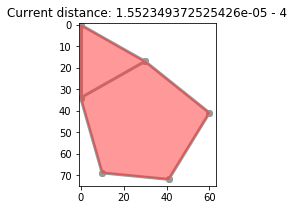

[[0.0, 0.0]]
[0.0, 0.0] [0.0, 0.0]
[[0.0, 0.0]]
[0.0, 34.0] [0.0, 0.0]
[[0.0, 0.0]]
[10.0, 69.0] [0.0, 0.0]
[[0.0, 0.0]]
[30.0, 17.0] [0.0, 0.0]
[[0.0006659792730658864, -0.0026639170922635458]]
[40.999334020726934, 72.00266391709226] [0.0006659792730658864, -0.0026639170922635458]
[[0.0019979378191834485, -0.0019979378191834485]]
[59.99800206218082, 41.00199793781918] [0.0019979378191834485, -0.0019979378191834485]


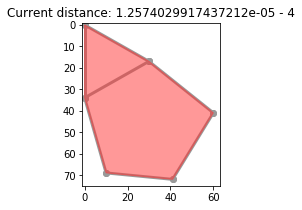

[[0.0, 0.0]]
[0.0, 0.0] [0.0, 0.0]
[[0.0, 0.0]]
[0.0, 34.0] [0.0, 0.0]
[[0.0, 0.0]]
[10.0, 69.0] [0.0, 0.0]
[[0.0, 0.0]]
[30.0, 17.0] [0.0, 0.0]
[[0.0005993813457578767, -0.002397525383031507]]
[40.99940061865424, 72.00239752538303] [0.0005993813457578767, -0.002397525383031507]
[[0.0017981440372665247, -0.0017981440372665247]]
[59.99820185596273, 41.00179814403727] [0.0017981440372665247, -0.0017981440372665247]


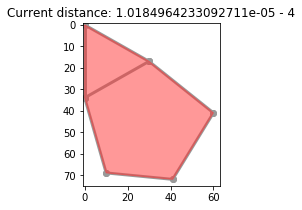

[[0.0, 0.0]]
[0.0, 0.0] [0.0, 0.0]
[[0.0, 0.0]]
[0.0, 34.0] [0.0, 0.0]
[[0.0, 0.0]]
[10.0, 69.0] [0.0, 0.0]
[[0.0, 0.0]]
[30.0, 17.0] [0.0, 0.0]
[[0.0005394432111813785, -0.002157772844725514]]
[40.99946055678882, 72.00215777284473] [0.0005394432111813785, -0.002157772844725514]
[[0.00161832963353703, -0.00161832963353703]]
[59.99838167036646, 41.00161832963354] [0.00161832963353703, -0.00161832963353703]


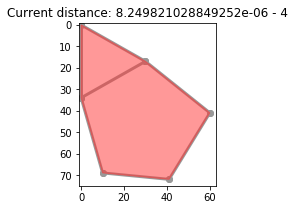

[[0.0, 0.0]]
[0.0, 0.0] [0.0, 0.0]
[[0.0, 0.0]]
[0.0, 34.0] [0.0, 0.0]
[[0.0, 0.0]]
[10.0, 69.0] [0.0, 0.0]
[[0.0, 0.0]]
[30.0, 17.0] [0.0, 0.0]
[[0.00048549889006466174, -0.001941995560258647]]
[40.999514501109935, 72.00194199556026] [0.00048549889006466174, -0.001941995560258647]
[[0.0014564966701868798, -0.0014564966701868798]]
[59.99854350332981, 41.00145649667019] [0.0014564966701868798, -0.0014564966701868798]


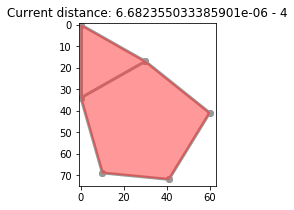

[[0.0, 0.0]]
[0.0, 0.0] [0.0, 0.0]
[[0.0, 0.0]]
[0.0, 34.0] [0.0, 0.0]
[[0.0, 0.0]]
[10.0, 69.0] [0.0, 0.0]
[[0.0, 0.0]]
[30.0, 17.0] [0.0, 0.0]
[[0.00043694900105606393, -0.0017477960042384666]]
[40.999563050998944, 72.00174779600424] [0.00043694900105606393, -0.0017477960042384666]
[[0.0013108470031681918, -0.0013108470031681918]]
[59.99868915299683, 41.00131084700317] [0.0013108470031681918, -0.0013108470031681918]


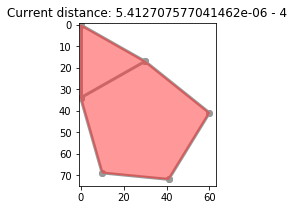

[[0.0, 0.0]]
[0.0, 0.0] [0.0, 0.0]
[[0.0, 0.0]]
[0.0, 34.0] [0.0, 0.0]
[[0.0, 0.0]]
[10.0, 69.0] [0.0, 0.0]
[[0.0, 0.0]]
[30.0, 17.0] [0.0, 0.0]
[[0.00039325410094903646, -0.0015730164038103567]]
[40.99960674589905, 72.00157301640381] [0.00039325410094903646, -0.0015730164038103567]
[[0.0011797623028542148, -0.0011797623028542148]]
[59.998820237697146, 41.001179762302854] [0.0011797623028542148, -0.0011797623028542148]


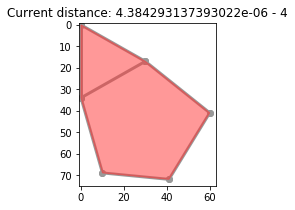

[[0.0, 0.0]]
[0.0, 0.0] [0.0, 0.0]
[[0.0, 0.0]]
[0.0, 34.0] [0.0, 0.0]
[[0.0, 0.0]]
[10.0, 69.0] [0.0, 0.0]
[[0.0, 0.0]]
[30.0, 17.0] [0.0, 0.0]
[[0.00035392869085626444, -0.0014157147634250578]]
[40.999646071309144, 72.00141571476343] [0.00035392869085626444, -0.0014157147634250578]
[[0.0010617860725687933, -0.0010617860725687933]]
[59.99893821392743, 41.00106178607257] [0.0010617860725687933, -0.0010617860725687933]


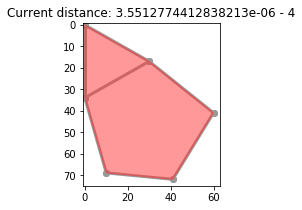

[[0.0, 0.0]]
[0.0, 0.0] [0.0, 0.0]
[[0.0, 0.0]]
[0.0, 34.0] [0.0, 0.0]
[[0.0, 0.0]]
[10.0, 69.0] [0.0, 0.0]
[[0.0, 0.0]]
[30.0, 17.0] [0.0, 0.0]
[[0.0003185358217692169, -0.0012741432870768676]]
[40.99968146417823, 72.00127414328708] [0.0003185358217692169, -0.0012741432870768676]
[[0.0009556074653147562, -0.0009556074653147562]]
[59.999044392534685, 41.000955607465315] [0.0009556074653147562, -0.0009556074653147562]


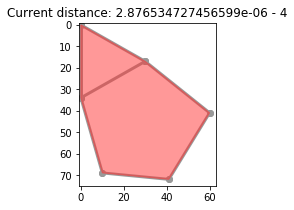

[[0.0, 0.0]]
[0.0, 0.0] [0.0, 0.0]
[[0.0, 0.0]]
[0.0, 34.0] [0.0, 0.0]
[[0.0, 0.0]]
[10.0, 69.0] [0.0, 0.0]
[[0.0, 0.0]]
[30.0, 17.0] [0.0, 0.0]
[[0.0002866822395901636, -0.0011467289583748652]]
[40.99971331776041, 72.00114672895837] [0.0002866822395901636, -0.0011467289583748652]
[[0.0008600467187847016, -0.0008600467187847016]]
[59.999139953281215, 41.000860046718785] [0.0008600467187847016, -0.0008600467187847016]


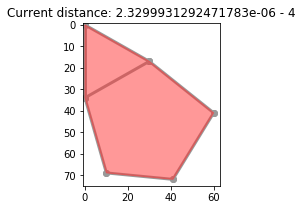

[[0.0, 0.0]]
[0.0, 0.0] [0.0, 0.0]
[[0.0, 0.0]]
[0.0, 34.0] [0.0, 0.0]
[[0.0, 0.0]]
[10.0, 69.0] [0.0, 0.0]
[[0.0, 0.0]]
[30.0, 17.0] [0.0, 0.0]
[[0.00025801401562830506, -0.001032056062541642]]
[40.99974198598437, 72.00103205606254] [0.00025801401562830506, -0.001032056062541642]
[[0.0007740420469062315, -0.0007740420469062315]]
[59.999225957953094, 41.000774042046906] [0.0007740420469062315, -0.0007740420469062315]


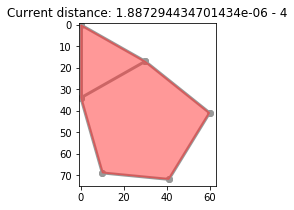

[[0.0, 0.0]]
[0.0, 0.0] [0.0, 0.0]
[[0.0, 0.0]]
[0.0, 34.0] [0.0, 0.0]
[[0.0, 0.0]]
[10.0, 69.0] [0.0, 0.0]
[[0.0, 0.0]]
[30.0, 17.0] [0.0, 0.0]
[[0.00023221261406547455, -0.0009288504562903199]]
[40.999767787385935, 72.00092885045629] [0.00023221261406547455, -0.0009288504562903199]
[[0.0006966378422177399, -0.0006966378422177399]]
[59.99930336215778, 41.00069663784222] [0.0006966378422177399, -0.0006966378422177399]


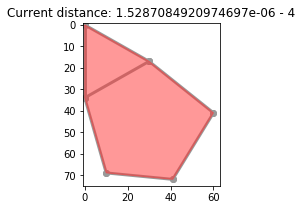

[[0.0, 0.0]]
[0.0, 0.0] [0.0, 0.0]
[[0.0, 0.0]]
[0.0, 34.0] [0.0, 0.0]
[[0.0, 0.0]]
[10.0, 69.0] [0.0, 0.0]
[[0.0, 0.0]]
[30.0, 17.0] [0.0, 0.0]
[[0.000208991352657506, -0.0008359654106584458]]
[40.99979100864734, 72.00083596541066] [0.000208991352657506, -0.0008359654106584458]
[[0.0006269740579938343, -0.0006269740579938343]]
[59.999373025942006, 41.000626974057994] [0.0006269740579938343, -0.0006269740579938343]


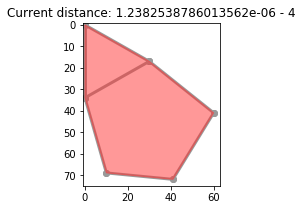

[[0.0, 0.0]]
[0.0, 0.0] [0.0, 0.0]
[[0.0, 0.0]]
[0.0, 34.0] [0.0, 0.0]
[[0.0, 0.0]]
[10.0, 69.0] [0.0, 0.0]
[[0.0, 0.0]]
[30.0, 17.0] [0.0, 0.0]
[[0.00018809221739246595, -0.0007523688695982855]]
[40.99981190778261, 72.0007523688696] [0.00018809221739246595, -0.0007523688695982855]
[[0.0005642766521916087, -0.0005642766521916087]]
[59.99943572334781, 41.00056427665219] [0.0005642766521916087, -0.0005642766521916087]


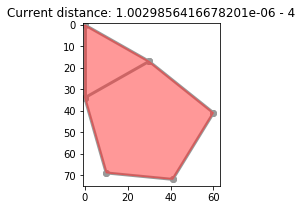

[[0.0, 0.0]]
[0.0, 0.0] [0.0, 0.0]
[[0.0, 0.0]]
[0.0, 34.0] [0.0, 0.0]
[[0.0, 0.0]]
[10.0, 69.0] [0.0, 0.0]
[[0.0, 0.0]]
[30.0, 17.0] [0.0, 0.0]
[[0.00016928299565677207, -0.0006771319826412991]]
[40.99983071700434, 72.00067713198264] [0.00016928299565677207, -0.0006771319826412991]
[[0.0005078489869703162, -0.0005078489869703162]]
[59.99949215101303, 41.00050784898697] [0.0005078489869703162, -0.0005078489869703162]


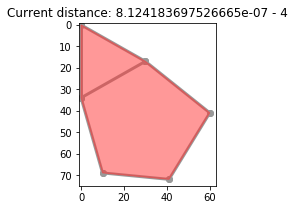

[[0.0, 0.0]]
[0.0, 0.0] [0.0, 0.0]
[[0.0, 0.0]]
[0.0, 34.0] [0.0, 0.0]
[[0.0, 0.0]]
[10.0, 69.0] [0.0, 0.0]
[[0.0, 0.0]]
[30.0, 17.0] [0.0, 0.0]
[[0.00015235469609109487, -0.0006094187843785903]]
[40.99984764530391, 72.00060941878438] [0.00015235469609109487, -0.0006094187843785903]
[[0.0004570640882732846, -0.0004570640882732846]]
[59.99954293591173, 41.00045706408827] [0.0004570640882732846, -0.0004570640882732846]


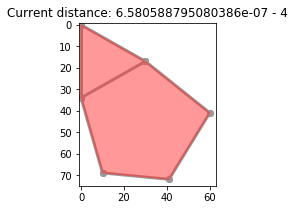

[[0.0, 0.0]]
[0.0, 0.0] [0.0, 0.0]
[[0.0, 0.0]]
[0.0, 34.0] [0.0, 0.0]
[[0.0, 0.0]]
[10.0, 69.0] [0.0, 0.0]
[[0.0, 0.0]]
[30.0, 17.0] [0.0, 0.0]
[[0.00013711922647985375, -0.0005484769059478367]]
[40.99986288077352, 72.00054847690595] [0.00013711922647985375, -0.0005484769059478367]
[[0.0004113576794466667, -0.0004113576794466667]]
[59.99958864232055, 41.00041135767945] [0.0004113576794466667, -0.0004113576794466667]


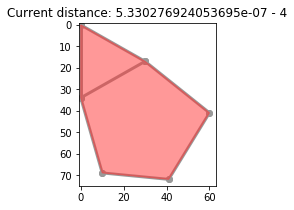

[[0.0, 0.0]]
[0.0, 0.0] [0.0, 0.0]
[[0.0, 0.0]]
[0.0, 34.0] [0.0, 0.0]
[[0.0, 0.0]]
[10.0, 69.0] [0.0, 0.0]
[[0.0, 0.0]]
[30.0, 17.0] [0.0, 0.0]
[[0.00012340730383186838, -0.0004936292153558952]]
[40.99987659269617, 72.00049362921536] [0.00012340730383186838, -0.0004936292153558952]
[[0.00037022191150271055, -0.00037022191150271055]]
[59.9996297780885, 41.0003702219115] [0.00037022191150271055, -0.00037022191150271055]


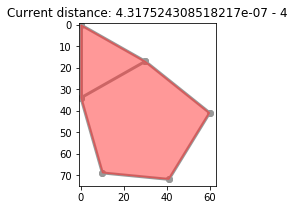

[[0.0, 0.0]]
[0.0, 0.0] [0.0, 0.0]
[[0.0, 0.0]]
[0.0, 34.0] [0.0, 0.0]
[[0.0, 0.0]]
[10.0, 69.0] [0.0, 0.0]
[[0.0, 0.0]]
[30.0, 17.0] [0.0, 0.0]
[[0.00011106657344583937, -0.00044426629382599003]]
[40.999888933426554, 72.00044426629383] [0.00011106657344583937, -0.00044426629382599003]
[[0.00033319972035172896, -0.00033319972035172896]]
[59.99966680027965, 41.00033319972035] [0.00033319972035172896, -0.00033319972035172896]


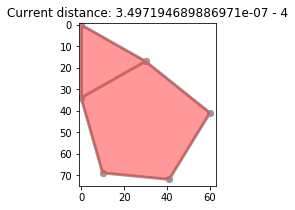

[[0.0, 0.0]]
[0.0, 0.0] [0.0, 0.0]
[[0.0, 0.0]]
[0.0, 34.0] [0.0, 0.0]
[[0.0, 0.0]]
[10.0, 69.0] [0.0, 0.0]
[[0.0, 0.0]]
[30.0, 17.0] [0.0, 0.0]
[[9.99599160991238e-05, -0.0003998396644391278]]
[40.9999000400839, 72.00039983966444] [9.99599160991238e-05, -0.0003998396644391278]
[[0.0002998797483186877, -0.0002998797483186877]]
[59.99970012025168, 41.00029987974832] [0.0002998797483186877, -0.0002998797483186877]


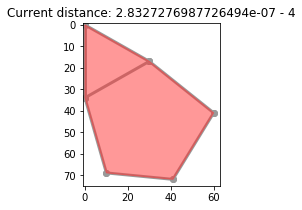

[[0.0, 0.0]]
[0.0, 0.0] [0.0, 0.0]
[[0.0, 0.0]]
[0.0, 34.0] [0.0, 0.0]
[[0.0, 0.0]]
[10.0, 69.0] [0.0, 0.0]
[[0.0, 0.0]]
[30.0, 17.0] [0.0, 0.0]
[[8.996392448779034e-05, -0.0003598556979937939]]
[40.99991003607551, 72.000359855698] [8.996392448779034e-05, -0.0003598556979937939]
[[0.0002698917734846873, -0.0002698917734846873]]
[59.999730108226515, 41.000269891773485] [0.0002698917734846873, -0.0002698917734846873]


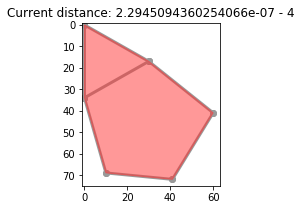

[[0.0, 0.0]]
[0.0, 0.0] [0.0, 0.0]
[[0.0, 0.0]]
[0.0, 34.0] [0.0, 0.0]
[[0.0, 0.0]]
[10.0, 69.0] [0.0, 0.0]
[[0.0, 0.0]]
[30.0, 17.0] [0.0, 0.0]
[[8.096753204256402e-05, -0.0003238701281986778]]
[40.99991903246796, 72.0003238701282] [8.096753204256402e-05, -0.0003238701281986778]
[[0.00024290259613479748, -0.00024290259613479748]]
[59.999757097403865, 41.000242902596135] [0.00024290259613479748, -0.00024290259613479748]


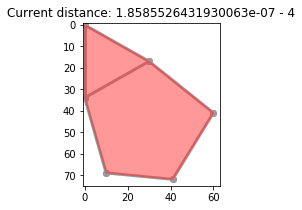

[[0.0, 0.0]]
[0.0, 0.0] [0.0, 0.0]
[[0.0, 0.0]]
[0.0, 34.0] [0.0, 0.0]
[[0.0, 0.0]]
[10.0, 69.0] [0.0, 0.0]
[[0.0, 0.0]]
[30.0, 17.0] [0.0, 0.0]
[[7.287077883688653e-05, -0.00029148311537596783]]
[40.99992712922116, 72.00029148311538] [7.287077883688653e-05, -0.00029148311537596783]
[[0.00021861233652487044, -0.00021861233652487044]]
[59.999781387663475, 41.000218612336525] [0.00021861233652487044, -0.00021861233652487044]


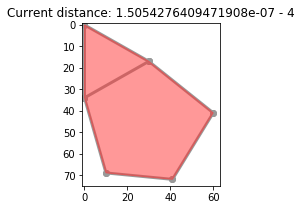

[[0.0, 0.0]]
[0.0, 0.0] [0.0, 0.0]
[[0.0, 0.0]]
[0.0, 34.0] [0.0, 0.0]
[[0.0, 0.0]]
[10.0, 69.0] [0.0, 0.0]
[[0.0, 0.0]]
[30.0, 17.0] [0.0, 0.0]
[[6.558370095177679e-05, -0.0002623348038355289]]
[40.99993441629905, 72.00026233480384] [6.558370095177679e-05, -0.0002623348038355289]
[[0.00019675110286954123, -0.00019675110286954123]]
[59.99980324889713, 41.00019675110287] [0.00019675110286954123, -0.00019675110286954123]


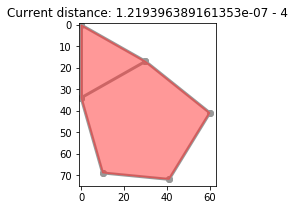

[[0.0, 0.0]]
[0.0, 0.0] [0.0, 0.0]
[[0.0, 0.0]]
[0.0, 34.0] [0.0, 0.0]
[[0.0, 0.0]]
[10.0, 69.0] [0.0, 0.0]
[[0.0, 0.0]]
[30.0, 17.0] [0.0, 0.0]
[[5.902533085588857e-05, -0.00023610132345197599]]
[40.999940974669144, 72.00023610132345] [5.902533085588857e-05, -0.00023610132345197599]
[[0.00017707599258187656, -0.00017707599258187656]]
[59.99982292400742, 41.00017707599258] [0.00017707599258187656, -0.00017707599258187656]


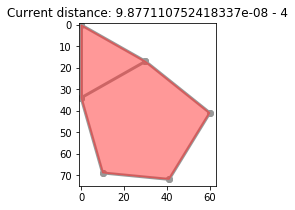

In [775]:
hole_poly = Polygon(data['hole'])
figure = data['figure']
vertices = figure['vertices']
edges = figure['edges']
epsilon=data['epsilon']
figure_shape = MultiLineString([(vertices[s], vertices[e]) for s, e in edges])
delta=0.1
n = len(sources)
# magnets={
#     0:[4],1:[3], 2:[2], 3:[0], 4:[1]
# }

# magnets = {
#     0:[0], 1:[4], 2:[1], 3:[3], 4:[2]
# } # 16
# magnets = {
#     0:[8],  2: [7] #1:[8, 0],
# } # 14
# magnets={
#     0: [3], 1: [0], 2: [2], 3: [1]
# } # 13
#magnets = {
#    0: [2], 1: [0], 2: [0], 3: [1]
#} # 12
# magnets = {
# #     0: [3],
# #     1: [0],
# #     2: [2],
# #     4: [0, 3],
# #     3: [1]
    
# #     0: [0],
# #     1: [1],
# #     2: [3],
# #     3: [2],
# #     4: [0, 1]
    
#     0: [2],
#     1: [1],
#     2: [3],
#     4: [2, 1],
#     3: [0]
# #     0: [2],
# #     1: [1],
# #     2: [3],
# #     3: [0],
# #     4 : [1, 2]
# } # 15
# # magnets = {
# #     #0: [1]
# #     1: [0]
# # } # 22
32410
# magnets = {
#     0: [5],
#     1: [4], #1

#     5: [2],
#     4: [3],
#     3: [1],
#     2: [0],
#     # 2:[4]
#     #2: [2]
# } ## 22
magnets = {
    0 : [0], 
    1: [5],
    2: [4],
    3: [1],
    4: [3],
    5: [2]
}
#23

current_pos = sources
magnets_ = magnets
for k in range(100):
    if k > 40:
        magnets_ = {k:v for k, v in magnets.items() if len(v)==1}
    #if k > 70:
    #    magnets_= dict()
    forces = compute_forces(current_pos, orig_edges, targets, sources, epsilon, magnets=magnets_)
    current_pos = [modify_pos(current_pos[i], delta, forces[i]) for i in range(n)]
    # print(current_pos)
    figure_shape = MultiLineString([(current_pos[s], current_pos[e]) for s, e in edges])

    #if i%2==0:
    draw_pair(hole_poly, figure_shape, filename=None, label=str(i), new_vert=current_pos)

In [776]:
sources

[[0, 0], [0, 34], [10, 69], [30, 17], [39, 80], [54, 47]]

In [777]:
targets

[[0, 0], [30, 17], [60, 41], [41, 72], [10, 69], [0, 34]]

In [778]:
def validate_distance(v, u, new_v, new_u, epsilon=0):
    old_d = get_dist(v, u)
    new_d = get_dist(new_v, new_u)
    return np.abs(new_d/old_d - 1)<= epsilon/1000000
def get_approximated(edges, new_vertices, vertices, epsilon=0):
    neighbors = defaultdict(set)

    for x, y in edges:
        #if x > y:
        neighbors[x].add(y)
        #else:
        neighbors[y].add(x)
    
    sequences = []
    for i, (x, y) in enumerate(new_vertices):
        xa, xb = int(np.floor(x)), int(np.ceil(x))
        ya, yb = int(np.floor(y)), int(np.ceil(y))
        variants = [(xa, ya)]
        if ya != yb:
            variants.append((xa, yb))
        if xa != xb:
            variants.append((xb, ya))
            if ya!=yb:
                variants.append((xb, yb))
        # print(i, variants)
        if i == 0:
            new_sequences = []
            for v in variants:
                new_sequences.append([v])
            sequences = new_sequences
            continue
        new_sequences = []
        for prefix in sequences:
            for v in variants:
                neigh = [s for s in neighbors[i] if s < i]
                val_results = [
                    validate_distance(vertices[s], vertices[i], prefix[s], v, epsilon=epsilon)
                    for s in neigh
                ] + [True]
                if not np.all(val_results):
                    continue

                new_sequences.append(prefix + [v])
                # print(i, prefix, v, neighbors[i])
        sequences = new_sequences
    return sequences

def get_best_sequences(approx_sequences, data):
    new_seq = []
    min_dist = None
    for seq in approx_sequences:
        dist_data = [
            np.min([get_dist(p, q) for q in seq])
            for p in data['hole']
        ]
        dist = np.sum(dist_data)
        if min_dist is None or min_dist > dist:
            min_dist = dist
            new_seq = [seq]
        elif dist == min_dist:
            new_seq.append(seq)
    return min_dist, new_seq

In [779]:
current_pos, edges

([[0.0, 0.0],
  [0.0, 34.0],
  [10.0, 69.0],
  [30.0, 17.0],
  [40.99994687720223, 72.0002124911911],
  [59.99984063160667, 41.00015936839333]],
 [[0, 1], [0, 3], [1, 2], [1, 3], [2, 4], [3, 5], [4, 5]])

In [780]:
vertices = data['figure']['vertices']
pos_round = [[np.round(x), np.round(y)] for x, y in current_pos]
sequences = get_approximated(edges, current_pos, vertices, epsilon=data['epsilon'])
dist, approx_vertices_seqs = get_best_sequences(sequences, data)

print(dist)
figures = [
    (nvert, MultiLineString([(nvert[s], nvert[e]) for s, e in edges]))
    for nvert in approx_vertices_seqs
]
# figures = [(vert, fig) for vert, fig in figures if check_poly(hole_poly, fig)]
print(figures)
current_pos, targets, {"vertices":[[np.round(x), np.round(y)] for x, y in current_pos]}


0
[([(0, 0), (0, 34), (10, 69), (30, 17), (41, 72), (60, 41)], <shapely.geometry.multilinestring.MultiLineString object at 0x7f78688f0f50>)]


([[0.0, 0.0],
  [0.0, 34.0],
  [10.0, 69.0],
  [30.0, 17.0],
  [40.99994687720223, 72.0002124911911],
  [59.99984063160667, 41.00015936839333]],
 [[0, 0], [30, 17], [60, 41], [41, 72], [10, 69], [0, 34]],
 {'vertices': [[0.0, 0.0],
   [0.0, 34.0],
   [10.0, 69.0],
   [30.0, 17.0],
   [41.0, 72.0],
   [60.0, 41.0]]})

In [781]:
vertices = {"vertices":[[np.round(x), np.round(y)] for x, y in current_pos]}
datadir = f"../solutions/{problem_id}/geom_0"
if not os.path.exists(datadir):
    os.makedirs(datadir)
with open(f"{datadir}/solution.json", 'w') as f:
    json.dump(vertices, f)

In [756]:
current_pos

[[0.004841792804888837, 18.008180960256535],
 [29.000079684196663, 34.99997343860111],
 [29.99499124882253, 0.007847043511371577],
 [63.99569638118303, 1.0044381069050028],
 [63.99398949858704, 34.99446401185648],
 [93.97305072941866, 18.00114677747155]]

In [757]:
vertices = figure['vertices']
problem_id

22

In [441]:
targets

[[34, 0], [17, 30], [10, 62], [13, 30], [0, 0]]

In [442]:
figure
vs = figure['vertices']
es = figure['edges']

In [443]:
import networkx as nx 
G = nx.Graph()

In [444]:
for i in range(len(vs)):
    G.add_node(i)
for s, e in es:
    weight = get_dist(vs[s], vs[e])
    G.add_edge(s, e, weight=weight)
    #G.add_edge(e, s, weight=weight)

In [445]:
nx.planar_layout(G)

{0: array([-0.875, -0.375]),
 1: array([-0.5625, -0.0625]),
 2: array([0.0625, 0.5625]),
 3: array([ 1.   , -0.375]),
 4: array([0.375, 0.25 ])}

In [480]:
def vect(u, v):
    return [y-x for x, y in zip(u, v)]
def vsum(u, v):
    return [y+x for x, y in zip(u, v)]
def mult(u, m):
    return [x*m for x in u]
def dot(u, v):
    return np.sum([x*y for x, y in zip(u, v)])

def length(u):
    return np.sqrt(dot(u, u))

def projection(u, v):
    return dot(u, v)/length(v)
def norm(u):
    m = 1./(length(u)+1e-8)
    return mult(u, m)
    

def flip_points(current_vertices, i, j, points=[]):
    new_vertices = [[x, y] for x, y in current_vertices]
    if len(points) == 0:
        return new_vertices
    a = current_vertices[i]
    b = current_vertices[j]
    v0 = norm(vect(a, b))
    for k in points:
        c = current_vertices[k]
        u = vect(a, c)
        p = mult(v0, projection(u, v0))
        
        n = vsum(mult(p, -1), u)
        new_pos = vsum(a, vsum(mult(n, -1), p))
        new_vertices[k] = new_pos
    return new_vertices[k]
    
    
class MovePoint:
    def __init__(self, vertices, edges, epsilon=0):
        self.vertices = vertices
        self.edges = edges
        self.epsilon = epsilon
    
    @property
    def is_useful(self):
        return True
    def __call__(self, vertices, edges):
        pass

class FlipEar:
    def __init__(self, vertices, edges, epsilon=0):
        self.vertices = vertices
        self.edges = edges
        self.neighbors = defaultdict(set)
        for s, e in edges:
            self.neighbors[s].add(e)
            self.neighbors[e].add(s)
        self.ears = [
            s for s, n in self.neighbors.items()
            if len(n) == 2
        ]
        pass
    @property
    def is_useful(self):
        return len(self.ears) > 0
    def __call__(self, current_vertices):
        e = np.random.choice(self.ears)
        # todo: flip point
        i, j = list(self.neighbors[e])
        return flip_points(current_vertices, i, j, points=[e])

class RotateSplitPoint:
    def __init__(self, vertices, edges, epsilon=0):
        pass
    def is_useful(self):
        pass
    def __call__(self):
        pass

class Flip2Points:
    def __init__(self, vertices, edges, epsilon=0):
        print("11")
        self.vertices = vertices
        self.edges = edges
        self.epsilon = epsilon
        n = len(vertices)
        g = Graph()
        g.add_vertices(n)
        g.add_edges(edges)
        self.pairs = dict()
        assert np.unique(g.clusters(mode='weak').membership).shape[0] <= 1

        #print(n, vertices)
        for i in range(n - 1):
            for j in range(i + 1, n):
                #print(i, j)
                g = Graph()
                g.add_vertices(n)
                sel_edges = [
                    (x, y)
                    for x, y in edges
                    if x not in (i, j) and y not in (i, j)
                ]
                #print(edges)
                if len(sel_edges) < 1:
                    continue
                #print(sel_edges)
                g.add_edges(sel_edges)
                clusters = g.clusters(mode='weak')
                #c = components.membership[i]
                components = defaultdict(set)
                for k, c in zip(range(n), clusters.membership):
                    components[c].add(k)
                components = [list(c) for c in components.values()]
                if len(components) > 1:
                    self.pairs[(i, j)] = components
                    self.pairs[(j, i)] = components
    @property
    def is_useful(self):
        return len(self.pairs) > 0

    def __call__(self, current_vertices):
        i, j = np.random.choice(self.pairs)
        sep = np.random.choice(self.pairs[(i, j)])
        # todo: flip point
        return flip_points(current_vertices, i, j, points=sep)
    

def mc_opt(edges, vertices, hole, moves=[], prob=0.1):
    pass


In [481]:
moves = [
    MovePoint(vertices, edges, epsilon=epsilon),
    FlipEar(vertices, edges, epsilon=epsilon),
    RotateSplitPoint(vertices, edges, epsilon=epsilon),
    Flip2Points(vertices, edges, epsilon=epsilon)
]

11


In [482]:
f2p = Flip2Points(vertices, edges, epsilon=epsilon)

11


In [484]:
f2p.is_useful

True